# Unsupervised Learning Capstone

For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

Be prepared to talk about:

Your end-user and the value your project provides to them. <br>
CDC, EMPRES, WHO
Further understanding of disease outbreaks
Potentially able to predict


Quantifiable results based on the research you’ve conducted.<br>
Difference btween reporting and obsercation dates


The visuals you chose and what they represent for your research.<br>



Next steps you'd take to expand on your work.<br>
As always, more information
Perhaps look further back
Find a way to completely combine outbreaks into single data points


A specified research question your model addresses.<br>
How can we anticipate animal disease outbreaks?
How should we handle based on initial information?


How you chose your model specification and what alternatives you compared it to.<br>


The practical uses of your model for an audience of interest.<br>
How is this different from the question(s) the model addresses?

Any weak points or shortcomings of your model.<br>
1. The fact that I couldn't completely combine cases


# The Data

I've chosen to explore and analze data on [animal disease outbreaks](https://www.kaggle.com/tentotheminus9/empres-global-animal-disease-surveillance) found on Kaggle gathered by EMPRES Global Animal Disease Information System (EMPRES-i), an application created to assist veterinary services by providing information on global diseases. The ability to understand the inception and spread of these diseases and ultimately predict where and how future incidents/episodes will unfold is crucial in our efforts to combat the damage caused. While some may believe animals' health is irrelevant to us, this couldn't be farther from the truth - on an obvious level, because roughly 90% of the world's population eats meat it is advantageous for us to keep our fellow animals healthy. What is less known but perhaps even more important is that many epidemiologists believe it's likely that the next pandemic will come from an animal, similar to the SARS and MERS viruses that have killed hundreds.

The data includes just over 17,000 cases of animal outbreaks. Each row represents a different outbreak so there are some repeating diseases. Variables include timing, place, species, and diseases, as well as information on the number of animals and humans affected. I'll use clutering and other unsupervised learning in an effort to learn about the onset and dispersion of animal disease outbreaks. Ideally, the data will collect in such a way that I am able to differentiate/locate/predict outbreaks with pandemic potential. 

In [1]:
!pip install umap-learn

In [2]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
%matplotlib inline
from datetime import datetime, timedelta
import re


# from matplotlib import image
from sklearn.preprocessing import StandardScaler, normalize
from scipy.stats.mstats import winsorize
import scipy.stats as stats

# from keras.layers import Input,Dense
# from keras.models import Model

# import keras
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
# import hdbscan
from sklearn import datasets, metrics
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage as lnkg

from sklearn.neural_network import MLPClassifier, BernoulliRBM
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score, GridSearchCV

In [3]:
outbreaks1 = pd.read_csv('Outbreak1.csv')
outbreaks2 = pd.read_csv('Outbreak2.csv')
outbreaks3 = pd.read_csv('Outbreak3.csv')
outbreaks4 = pd.read_csv('Outbreak4.csv')
outbreaks5 = pd.read_csv('Outbreak5.csv')
outbreaks6 = pd.read_csv('Outbreak6.csv')
outbreaks = pd.DataFrame(outbreaks1.append([outbreaks2, outbreaks3, outbreaks4, outbreaks5, outbreaks6]))
print(outbreaks.columns)
print(outbreaks.info())

Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansGenderDesc', 'humansAge', 'humansAffected', 'humansDeaths'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 4999
Data columns (total 24 columns):
Id                    30000 non-null int64
source                30000 non-null object
latitude              30000 non-null float64
longitude             30000 non-null float64
region                30000 non-null object
country               30000 non-null object
admin1                30000 non-null object
localityName          30000 non-null object
localityQuality       30000 non-null object
observationDate       29314 non-null object
reportingDate         30000 non-null object
status     

In [4]:
print(outbreaks.humansAffected.value_counts())
print(outbreaks.humansDeaths.value_counts())

1.0      1589
0.0        16
3.0         2
11.0        1
5.0         1
78.0        1
100.0       1
145.0       1
24.0        1
4.0         1
2.0         1
Name: humansAffected, dtype: int64
1.0    434
0.0     32
2.0      2
6.0      1
3.0      1
Name: humansDeaths, dtype: int64


# The Cleaning

More than half of the variables are not missing any data which is a great start. Just under 7,000 rows are missing information on serotypes so I will fill these with 'Unknown Serotypes'. Similarly, under 2,000 rows are missing in speciesDescription, so these will be filled with 'Unknown Species'. Additionally, the information populating these cells are lists of animals so I will create new dummy variables with keywords, including 'wild' and 'domestic'. Finally, I'll create new features 'birds' and 'mammals' which will indicate whether a disease affected these classes.

Empty cells in sumAtRisk, sumCases, sumDeaths, sumDestroyed, sumSlaughtered, and humansAge will be filled with the mean value of these columns. I will drop the column humansGenderDesc as there is simply not enough information for me to populate the missing values. As for humansAffected and humansDeaths, I'll populate missing values with the mode. 

All dates in the data will be converted to datetime objects and create variables for the year, month, and day of the observation. Missing variables in observationDate will be filled by finding the average difference between the observationDate and reportingDate, and subtracting this number from the reportingDate. A new variable, 'differenceInDays', will be created by finding the difference between the observationDate and reportingDate for each instance.

Dummies will be created for source, region, country, localityQuality, disease, serotypes, and status.

In [5]:
outbreaks.serotypes.fillna('Unknown Serotypes', inplace=True)
outbreaks.speciesDescription.fillna('Unknown Species', inplace=True)
outbreaks.sumAtRisk.fillna(outbreaks.sumAtRisk.mean(), inplace=True)
outbreaks.sumCases.fillna(outbreaks.sumCases.mean(), inplace=True)
outbreaks.sumDeaths.fillna(outbreaks.sumDeaths.mean(), inplace=True)
outbreaks.sumDestroyed.fillna(outbreaks.sumDestroyed.mean(), inplace=True)
outbreaks.sumSlaughtered.fillna(outbreaks.sumSlaughtered.mean(), inplace=True)
outbreaks.drop(columns=['humansGenderDesc'], inplace=True)
outbreaks.humansAge.fillna(outbreaks.humansAge.mean(), inplace=True)
outbreaks.humansAffected.fillna(outbreaks.humansAffected.mode()[0], inplace=True)
outbreaks.humansDeaths.fillna(outbreaks.humansDeaths.mode()[0], inplace=True)

In [6]:
print('Reporting Dates: \n', outbreaks.reportingDate.head())
print('Observation Dates: \n', outbreaks.observationDate.head())

Reporting Dates: 
 0    19/12/2019
1    23/12/2019
2    23/12/2019
3    23/12/2019
4    23/12/2019
Name: reportingDate, dtype: object
Observation Dates: 
 0    17/09/2019
1    23/12/2019
2    23/12/2019
3    20/12/2019
4    19/12/2019
Name: observationDate, dtype: object


In [7]:
outbreaks['observationDate'] = pd.to_datetime(outbreaks['observationDate'])
outbreaks['reportingDate'] = pd.to_datetime(outbreaks['reportingDate'])
outbreaks_time = outbreaks[['observationDate', 'reportingDate']]
outbreaks_time.dropna(inplace=True)

# Find the average difference between observation and reporting dates
outbreaks_time['differenceInDays'] = (outbreaks_time['reportingDate'] - outbreaks_time['observationDate'])/np.timedelta64(1,'D')
                                                                     
print('Average difference between observation and reporting dates: ', outbreaks_time['differenceInDays'].mean())
outbreaks.observationDate.fillna(outbreaks.reportingDate - timedelta(days=33), inplace=True)

# Creating a new variable
outbreaks['differenceInDays'] = (outbreaks['reportingDate'] - outbreaks['observationDate'])/np.timedelta64(1,'D')

Average difference between observation and reporting dates:  29.083953059971346


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
outbreaks.differenceInDays.head()

0    93.0
1     0.0
2     0.0
3     3.0
4     4.0
Name: differenceInDays, dtype: float64

In [9]:
print(outbreaks.columns)
outbreaks.shape

Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge',
       'humansAffected', 'humansDeaths', 'differenceInDays'],
      dtype='object')


(30000, 24)

In [10]:
outbreaks['observationYear'] = pd.DatetimeIndex(outbreaks['observationDate']).year
outbreaks['observationMonth'] = pd.DatetimeIndex(outbreaks['observationDate']).month
outbreaks['observationDay'] = pd.DatetimeIndex(outbreaks['observationDate']).day
outbreaks['observationFirstHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x <= 15 else 0 )
outbreaks['observationSecondHalfMonth'] = outbreaks['observationDay'].apply(lambda x: 1 if x > 15 else 0 )

In [11]:
print('Unique values in source: ', len(outbreaks.source.unique()))
print('Unique values in region: ', len(outbreaks.region.unique()))
print('Unique values in country: ', len(outbreaks.country.unique()))
print('Unique values in admin1: ', len(outbreaks.admin1.unique()))
print('Unique values in localityName: ', len(outbreaks.localityName.unique()))
print('Unique values in localityQuality: ', len(outbreaks.localityQuality.unique()))
print('Unique values in status: ', len(outbreaks.status.unique()))
print('Unique values in disease: ', len(outbreaks.disease.unique()))
print('Unique values in serotypes: ', len(outbreaks.serotypes.unique()))
print('Unique values in speciesDescription: ', len(outbreaks.speciesDescription.unique()))

Unique values in source:  14
Unique values in region:  4
Unique values in country:  140
Unique values in admin1:  1312
Unique values in localityName:  16763
Unique values in localityQuality:  5
Unique values in status:  2
Unique values in disease:  25
Unique values in serotypes:  62
Unique values in speciesDescription:  371


In [12]:
print('Unique values in source: ', outbreaks.source.unique())
print('Unique values in region: ', outbreaks.region.unique())
# print('Unique values in country: ', len(outbreaks.country.unique())
# print('Unique values in admin1: ', len(outbreaks.admin1.unique()))
# print('Unique values in localityName: ', len(outbreaks.localityName.unique()))
print('Unique values in localityQuality: ', outbreaks.localityQuality.unique())
print('Unique values in status: ', outbreaks.status.unique())
print('Unique values in disease: ', outbreaks.disease.unique())
print('Unique values in serotypes: ', outbreaks.serotypes.unique())
# print('Unique values in speciesDescription: ', len(outbreaks.speciesDescription.unique()))

Unique values in source:  ['OIE' 'Other' 'National authorities' 'FAO Field Officer' 'FAO-Report'
 'FAO ECTAD RAF' 'UN Field Officer' 'Media' 'WHO'
 'International reference laboratory'
 'National Institute for Communicable Diseases, NICD' 'EC' 'FAO officer'
 'sequence only']
Unique values in region:  ['Americas' 'Europe' 'Asia' 'Africa']
Unique values in localityQuality:  ['Exact' 'Centroid Locality' 'Centroid Admin1' 'Unknown' 'Centroid Admin2']
Unique values in status:  ['Confirmed' 'Denied']
Unique values in disease:  ['Newcastle disease' 'African swine fever' 'Foot and mouth disease'
 'Rabies' 'Influenza - Avian' 'Rift Valley fever' 'Bluetongue'
 'Classical swine fever' 'MERS-CoV ' 'West Nile Fever'
 'Lumpy skin disease' 'Equine infectious anaemia'
 'Peste des petits ruminants' 'Sheep pox and goat pox' 'Anthrax'
 'Influenza - Equine' 'Glanders' 'Bovine spongiform encephalopathy'
 'Contagious bovine pleuropneumonia' 'Brucellosis (Brucella abortus)'
 'Brucellosis (Brucella melitensis

In [13]:
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['source'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['region'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['country'])], axis=1)
outbreaks.drop(columns=['admin1', 'localityName'], inplace=True)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['localityQuality'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['status'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['disease'])], axis=1)
outbreaks = pd.concat([outbreaks, pd.get_dummies(outbreaks['serotypes'])], axis=1)

In [14]:
outbreaks['wild'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'wild' in x else 0)
outbreaks['undomestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'undomestic' in x else 0)
outbreaks['domestic'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'domestic' in x else 0)
outbreaks['captive'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'captive' in x else 0)
outbreaks['unspecified'] = outbreaks.speciesDescription.apply(lambda x: 1 if 'unspecified' in x else 0)
outbreaks.head(10)

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,...,O,SAT1,SAT2,SAT3,Unknown Serotypes,wild,undomestic,domestic,captive,unspecified
0,264093,OIE,18.240550,-70.282265,Americas,Dominican Republic,Exact,2019-09-17,2019-12-19,Confirmed,...,0,0,0,0,1,0,0,1,0,0
1,264044,OIE,44.109900,26.804200,Europe,Romania,Exact,2019-12-23,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
2,264043,OIE,44.931200,25.626100,Europe,Romania,Exact,2019-12-23,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
3,264042,OIE,45.161400,25.392900,Europe,Romania,Exact,2019-12-20,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
4,264041,OIE,44.974100,25.464800,Europe,Romania,Exact,2019-12-19,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
5,264040,OIE,45.194500,26.975600,Europe,Romania,Exact,2019-12-12,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
6,264039,OIE,47.190800,22.512200,Europe,Romania,Exact,2019-12-20,2019-12-23,Confirmed,...,0,0,0,0,1,1,0,0,0,0
7,264038,OIE,47.743900,23.311200,Europe,Romania,Exact,2019-12-14,2019-12-20,Confirmed,...,0,0,0,0,1,1,0,0,0,0
8,264037,OIE,44.818976,25.821518,Europe,Romania,Exact,2019-12-18,2019-12-20,Confirmed,...,0,0,0,0,1,1,0,0,0,0
9,264036,OIE,44.666521,23.574296,Europe,Romania,Exact,2019-12-16,2019-12-20,Confirmed,...,0,0,0,0,1,1,0,0,0,0


In [15]:
birds = ['bird', 'swan', 'turkey', 'mallard', 'goose', 'duck', 'pigeon', 'heron', 'accipitridae', 'gull', 
         'phasianidae', 'eagle', 'chicken', 'buzzard', 'falcon', 'anatidae', 'fowl', 'eider', 'pelican', 'wigeon',
        'dove', 'rook', 'stork', 'egret', ' peafowl', 'cormorant', 'coot', 'crow', 'scaup', 'teal', 'magpie', 
         'kestrel', 'blackbird', 'gadwall', 'pochard', 'shelduck', 'parrot', 'tern', ' grebe', 'flamingo', 'eagle-owl',
        'accipiter gentilis', 'ibis', 'ibex', 'emu', 'xpeacock', 'magpie-robin', ]
mammals = ['swine', 'boar', 'equidae', 'dog', 'sheep', 'cat', 'goat/sheep', 'goat', 'camelidae', 'horse',
          'fox', 'jackal', ' saiga', 'yaks', 'hippopotamus', 'buffaloe', 'deer', 'canine', 'elephant', 'mammal']
# number_of_species = figure it out
outbreaks['speciesDescription'] = outbreaks.speciesDescription.apply(lambda x: re.split('\s', x))
outbreaks['birds'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(birds)) > 0  else 0) 
outbreaks['mammals'] = outbreaks.speciesDescription.apply(lambda x: 1 if len(set(x) & set(mammals)) > 0  else 0)
outbreaks.head()

,Id,source,latitude,longitude,region,country,localityQuality,observationDate,reportingDate,status,...,SAT2,SAT3,Unknown Serotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals
0,264093,OIE,18.24055,-70.282265,Americas,Dominican Republic,Exact,2019-09-17,2019-12-19,Confirmed,...,0,0,1,0,0,1,0,0,1,0
1,264044,OIE,44.10990,26.804200,Europe,Romania,Exact,2019-12-23,2019-12-23,Confirmed,...,0,0,1,1,0,0,0,0,0,1
2,264043,OIE,44.93120,25.626100,Europe,Romania,Exact,2019-12-23,2019-12-23,Confirmed,...,0,0,1,1,0,0,0,0,0,1
3,264042,OIE,45.16140,25.392900,Europe,Romania,Exact,2019-12-20,2019-12-23,Confirmed,...,0,0,1,1,0,0,0,0,0,1
4,264041,OIE,44.97410,25.464800,Europe,Romania,Exact,2019-12-19,2019-12-23,Confirmed,...,0,0,1,1,0,0,0,0,0,1


There are just over 3,700 entries with observationDate values after reportingDates. While at first glance this may seem impossible, my guess is that these cases were observed after the initial reports so I will leave them.

In [16]:
# outbreaks[outbreaks['differenceInDays'] < 0].shape
# outbreaks = outbreaks[outbreaks.differenceInDays > 0]
# X.shape

In [17]:
sum_variables = ('sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAffected', 
                 'humansDeaths')
mean_variables = ('humansAge', 'differenceInDays', 'observationYear', 'observationMonth', 'observationDay', 
                  'observationFirstHalfMonth','observationSecondHalfMonth','EC', 'FAO ECTAD RAF', 'FAO Field Officer',
                  'FAO officer','FAO-Report', 'International reference laboratory', 'Media', 
                  'National Institute for Communicable Diseases, NICD', 'National authorities', 'OIE', 'Other', 
                  'UN Field Officer',' WHO', 'sequence only', 'Africa', 'Americas', 'Asia', 'Europe', 'Afghanistan',
                  'Albania','Algeria','Angola','Argentina','Armenia','Austria','Bahrain','Bangladesh','Belarus',
                  'Belgium','Belize','Bhutan','Bosnia and Herzegovina','Botswana','Brazil','Bulgaria','Burkina Faso',
                  'Burundi','Cambodia','Cameroon','Canada','Central African Republic','Chad','Chile','China','Colombia',
                  'Comoros','Croatia','Cyprus','Czech Republic','Côte d\'Ivoire','Dem People\'s Rep of Korea',
                  'Democratic Republic of the Congo','Denmark','Dominican Republic','Ecuador','Egypt','El Salvador',
                  'Estonia','Ethiopia','Finland','France','Gambia','Gaza Strip','Georgia','Germany','Ghana','Greece',
                  'Guinea','Guinea-Bissau','Honduras','Hong Kong, SAR','Hungary','India','Indonesia',
                  'Iran  (Islamic Republic of)','Iraq','Ireland','Israel','Italy','Japan','Jordan','Kazakhstan','Kenya',
                  'Kuwait','Kyrgyzstan','Lao People\'s Democratic Republic','Latvia','Lebanon','Lesotho','Libya',
                  'Lithuania','Luxembourg','Macau','Malawi','Malaysia','Maldives','Mali','Malta','Mauritania',
                  'Mauritius','Mayotte','Mexico','Moldova, Republic of','Mongolia','Montenegro','Morocco','Mozambique',
                  'Myanmar','Namibia','Nepal','Netherlands','Niger','Nigeria','Oman','Pakistan','Panama','Peru',
                  'Philippines','Poland','Portugal','Qatar','Republic of Korea','Romania','Russian Federation','Rwanda',
                  'Saudi Arabia','Senegal','Serbia','Sierra Leone','Slovakia','Slovenia','South Africa','South Sudan',
                  'Spain','Sudan','Svalbard and Jan Mayen Islands','Swaziland','Sweden','Switzerland','Syrian Arab Republic',
                  'Taiwan (Province of China)','Thailand','The former Yugoslav Republic of Macedonia','Timor-Leste',
                  'Togo','Tunisia','Turkey','U.K. of Great Britain and Northern Ireland','Uganda','Ukraine',
                  'United Arab Emirates','United Republic of Tanzania','United States of America','Uruguay',
                  'Viet Nam','West Bank','Zambia','Zimbabwe','Centroid Admin1','Centroid Admin2','Centroid Locality',
                  'Exact','Unknown','Confirmed','Denied','African horse sickness','African swine fever','Anthrax',
                  'Bluetongue','Bovine spongiform encephalopathy','Bovine tuberculosis','Brucellosis (Brucella abortus)',
                  'Brucellosis (Brucella melitensis)','Brucellosis (Brucella suis)','Classical swine fever',
                  'Contagious bovine pleuropneumonia','Equine infectious anaemia','Foot and mouth disease','Glanders',
                  'Influenza - Avian','Influenza - Equine','Lumpy skin disease','MERS-CoV','Newcastle disease',
                  'Peste des petits ruminants','Porcine reproductive and respiratory syndrome','Rabies',
                  'Rift Valley fever', 'Sheep pox and goat pox', 'West Nile Fever')
X = outbreaks.groupby([pd.Grouper(key='observationDate', freq='7D'),
    pd.Grouper(key='disease'),pd.Grouper(key='country')]).agg({'sumAtRisk':'sum','sumCases': 'sum','sumDeaths':'sum','sumDestroyed': 'sum','sumSlaughtered':'sum',
      'humansAffected': 'sum', 'humansDeaths': 'sum','humansAge':'mean','differenceInDays' : 'mean', 
      'observationYear': 'mean', 'observationMonth': 'mean', 'observationDay': 'mean', 'observationFirstHalfMonth': 'mean',
      'observationSecondHalfMonth': 'mean','EC': 'mean', 'FAO ECTAD RAF': 'mean', 'FAO Field Officer': 'mean',
    'FAO officer': 'mean','FAO-Report': 'mean', 'International reference laboratory': 'mean', 'Media': 'mean', 
    'National Institute for Communicable Diseases, NICD': 'mean', 'National authorities': 'mean', 'OIE': 'mean',
      'Other': 'mean', 'UN Field Officer': 'mean','WHO': 'mean', 'sequence only': 'mean', 'Africa': 'mean', 'Americas': 'mean',
      'Asia': 'mean', 'Europe': 'mean', 'Afghanistan': 'mean', 'Albania': 'mean','Algeria': 'mean','Angola': 'mean',
      'Argentina': 'mean','Armenia': 'mean','Austria': 'mean','Bahrain': 'mean','Bangladesh': 'mean','Belarus': 'mean',
    'Belgium': 'mean','Belize': 'mean','Bhutan': 'mean','Bosnia and Herzegovina': 'mean','Botswana': 'mean','Brazil': 'mean',
      'Bulgaria': 'mean','Burkina Faso': 'mean','Burundi': 'mean','Cambodia': 'mean','Cameroon': 'mean','Canada': 'mean',
      'Central African Republic': 'mean','Chad': 'mean','Chile': 'mean','China': 'mean','Colombia': 'mean',
     'Comoros': 'mean','Croatia': 'mean','Cyprus': 'mean','Czech Republic': 'mean','Côte d\'Ivoire': 'mean',
      'Dem People\'s Rep of Korea': 'mean',  'Democratic Republic of the Congo': 'mean','Denmark': 'mean','Dominican Republic': 'mean','Ecuador': 'mean',
      'Egypt': 'mean','El Salvador': 'mean','Estonia': 'mean','Ethiopia': 'mean','Finland': 'mean','France': 'mean',
      'Gambia': 'mean','Gaza Strip': 'mean','Georgia': 'mean','Germany': 'mean','Ghana': 'mean','Greece': 'mean',
    'Guinea': 'mean','Guinea-Bissau': 'mean','Honduras': 'mean','Hong Kong, SAR': 'mean','Hungary': 'mean',
    'India': 'mean','Indonesia': 'mean','Iraq': 'mean','Ireland': 'mean',
    'Israel': 'mean','Italy': 'mean','Japan': 'mean','Jordan': 'mean','Kazakhstan': 'mean','Kenya': 'mean',
    'Kuwait': 'mean','Kyrgyzstan': 'mean','Lao People\'s Democratic Republic': 'mean','Latvia': 'mean','Lebanon': 'mean',
      'Lesotho': 'mean','Libya': 'mean','Lithuania': 'mean','Luxembourg': 'mean','Macau': 'mean','Malawi': 'mean',
      'Malaysia': 'mean','Maldives': 'mean','Mali': 'mean','Malta': 'mean','Mauritania': 'mean','Mauritius': 'mean',
      'Mayotte': 'mean','Mexico': 'mean','Moldova, Republic of': 'mean','Mongolia': 'mean','Montenegro': 'mean',
      'Morocco': 'mean','Mozambique': 'mean','Myanmar': 'mean','Namibia': 'mean','Nepal': 'mean','Netherlands': 'mean',
      'Niger': 'mean','Nigeria': 'mean','Oman': 'mean','Pakistan': 'mean','Panama': 'mean','Peru': 'mean',
     'Philippines': 'mean','Poland': 'mean','Portugal': 'mean','Qatar': 'mean','Republic of Korea': 'mean',
      'Romania': 'mean','Russian Federation': 'mean','Rwanda': 'mean', 'Saudi Arabia': 'mean','Senegal': 'mean',
      'Serbia': 'mean','Sierra Leone': 'mean','Slovakia': 'mean','Slovenia': 'mean','South Africa': 'mean',
      'South Sudan': 'mean','Spain': 'mean','Sudan': 'mean','Svalbard and Jan Mayen Islands': 'mean','Swaziland': 'mean',
      'Sweden': 'mean','Switzerland': 'mean','Syrian Arab Republic': 'mean','Taiwan (Province of China)': 'mean',
      'Thailand': 'mean','The former Yugoslav Republic of Macedonia': 'mean','Timor-Leste': 'mean','Togo': 'mean',
      'Tunisia': 'mean','Turkey': 'mean','U.K. of Great Britain and Northern Ireland': 'mean','Uganda': 'mean',
      'Ukraine': 'mean', 'United Arab Emirates': 'mean','United Republic of Tanzania': 'mean',
      'United States of America': 'mean','Uruguay': 'mean','Viet Nam': 'mean','West Bank': 'mean','Zambia': 'mean',
      'Zimbabwe': 'mean','Centroid Admin1': 'mean','Centroid Admin2': 'mean','Centroid Locality': 'mean',
     'Exact': 'mean','Unknown': 'mean','Confirmed': 'mean','Denied': 'mean','African horse sickness': 'mean',
      'African swine fever': 'mean','Anthrax': 'mean','Bluetongue': 'mean','Bovine spongiform encephalopathy': 'mean',
      'Bovine tuberculosis': 'mean','Brucellosis (Brucella abortus)': 'mean', 'Brucellosis (Brucella melitensis)': 'mean',
      'Brucellosis (Brucella suis)': 'mean','Classical swine fever': 'mean','Contagious bovine pleuropneumonia': 'mean',
      'Equine infectious anaemia': 'mean','Foot and mouth disease': 'mean','Glanders': 'mean','Influenza - Avian': 'mean',
      'Influenza - Equine': 'mean','Lumpy skin disease': 'mean','MERS-CoV ': 'mean','Newcastle disease': 'mean',
    'Peste des petits ruminants': 'mean','Porcine reproductive and respiratory syndrome': 'mean','Rabies': 'mean',
    'Rift Valley fever': 'mean', 'Sheep pox and goat pox': 'mean', 'West Nile Fever': 'mean','1': 'mean','16': 'mean',
    '19': 'mean','2': 'mean','22': 'mean','3': 'mean','4': 'mean','5': 'mean','7': 'mean','8': 'mean','8, 4': 'mean',
      'A': 'mean','A, O': 'mean','APMV-I': 'mean','Asia 1': 'mean','H3 LPAI': 'mean','H3N1 LPAI': 'mean',
      'H3N8': 'mean','H5 HPAI': 'mean','H5 LPAI': 'mean','H5N1 HPAI': 'mean','H5N1 LPAI': 'mean','H5N1 LPAI, H5N2 LPAI': 'mean',
      'H5N2 HPAI': 'mean','H5N2 LPAI': 'mean','H5N2 LPAI, H6N2 LPAI': 'mean','H5N2 LPAI, H7N7 LPAI': 'mean',
      'H5N3 HPAI': 'mean','H5N3 LPAI': 'mean','H5N3 LPAI, H5N2 LPAI': 'mean','H5N5 HPAI': 'mean','H5N5 LPAI': 'mean',
      'H5N6 HPAI': 'mean','H5N6 LPAI': 'mean','H5N8 HPAI': 'mean','H5N8 HPAI, H5N2 HPAI': 'mean','H5N8 LPAI': 'mean',
      'H5N9 HPAI': 'mean','H5N9 LPAI': 'mean','H6N2 LPAI': 'mean','H7 LPAI': 'mean','H7N1 HPAI': 'mean','H7N1 LPAI': 'mean',
      'H7N2 LPAI': 'mean','H7N3 HPAI': 'mean','H7N3 LPAI': 'mean','H7N4 LPAI': 'mean','H7N6 LPAI': 'mean',
      'H7N7 HPAI': 'mean','H7N7 LPAI': 'mean','H7N9 HPAI': 'mean','H7N9 LPAI': 'mean','H9N2 LPAI': 'mean','HPAI': 'mean',
      'LPAI': 'mean','Not Specified': 'mean','Not specified': 'mean','O': 'mean','SAT1': 'mean','SAT2': 'mean',
      'SAT3': 'mean','Unknown Serotypes': 'mean','wild': 'mean','undomestic': 'mean','domestic': 'mean','captive': 'mean',
      'unspecified': 'mean','birds': 'mean','mammals': 'mean'})

print(X.shape)
pd.set_option('display.max_columns', None)
X.sort_values('observationDate', ascending=False).head(30)

(5831, 272)


sumAtRisk  \
observationDate disease             country                                    
2020-01-01      Influenza - Avian   Taiwan (Province of China)     20.000000   
                                    Poland                      19581.000000   
2019-12-25      African swine fever Latvia                      47642.392587   
                                    Romania                     13617.112168   
                                    Bulgaria                      175.000000   
                                    Hungary                     68060.560838   
                                    Republic of Korea           34030.280419   
                Rabies              Malaysia                        1.000000   
                Influenza - Avian   Poland                      78258.000000   
                                    Taiwan (Province of China)  44571.000000   
                                    China                          75.000000   
2019-12-18      African swine fever Latvia                      13612.112168   
                                    Romania                     54492.448671   
                                    Bulgaria                       48.000000   
                                    Hungary                      6806.056084   
                                    Republic of Korea           27224.224335   
                                    Russian Federation           6806.056084   
                Influenza - Avian   Taiwan (Province of China)   6239.000000   
                African swine fever China                         435.000000   
                Rabies              Malaysia                        3.000000   
                Influenza - Avian   Republic of Korea            6806.056084   
                MERS-CoV            Saudi Arabia                 6806.056084   
2019-12-11      African swine fever Russian Federation          13612.112168   
                                    Romania                     68212.560838   
                                    Bulgaria                    54448.448671   
                                    Moldova, Republic of         6806.056084   
                                    Hungary                      6806.056084   
                                    Poland                       6806.056084   
                                    Republic of Korea           27224.224335   
                Influenza - Avian   Republic of Korea            6806.056084   

                                                                    sumCases  \
observationDate disease             country                                    
2020-01-01      Influenza - Avian   Taiwan (Province of China)      2.000000   
                                    Poland                       7121.000000   
2019-12-25      African swine fever Latvia                          8.000000   
                                    Romania                         7.000000   
                                    Bulgaria                      175.000000   
                                    Hungary                       147.000000   
                                    Republic of Korea               5.000000   
                Rabies              Malaysia                        1.000000   
                Influenza - Avian   Poland                      70058.000000   
                                    Taiwan (Province of China)   5497.000000   
                                    China                           9.000000   
2019-12-18      African swine fever Latvia                          2.000000   
                                    Romania                        56.000000   
                                    Bulgaria                       48.000000   
                                    Hungary                        52.000000   
                                    Republic of Korea               4.000000   
                                    Russian Federation            

In [18]:
print(outbreaks.disease.value_counts())

# creating a dataframe including the eight most common diseases (diseases that showed up over 100 times)
top8_diseases = outbreaks[(outbreaks['Influenza - Avian'] == 1) | (outbreaks['Bluetongue'] == 1) |
                          (outbreaks['African swine fever'] == 1) | (outbreaks['Lumpy skin disease'] == 1)|
                          (outbreaks['MERS-CoV '] == 1) | (outbreaks['Foot and mouth disease'] == 1)|
                          (outbreaks['Newcastle disease'] == 1) | (outbreaks['Sheep pox and goat pox'] == 1)]


African swine fever                              12165
Influenza - Avian                                 7257
Bluetongue                                        3770
Lumpy skin disease                                2131
Foot and mouth disease                            1436
MERS-CoV                                           874
Classical swine fever                              572
Rabies                                             483
Newcastle disease                                  268
Peste des petits ruminants                         205
Sheep pox and goat pox                             187
Influenza - Equine                                 150
Anthrax                                            147
West Nile Fever                                    133
Rift Valley fever                                  107
Equine infectious anaemia                           44
African horse sickness                              22
Bovine spongiform encephalopathy                    13
Porcine re

# Visualizations

I'll focus on patterns found relating the numerical variables (those beginning with either 'sum' or 'humans') to the others as these would be the values that determine whether or not a disease is a serious threat. 

## Timing

ConversionError: Failed to convert value(s) to axis units: Timestamp('2014-01-01 00:00:00')

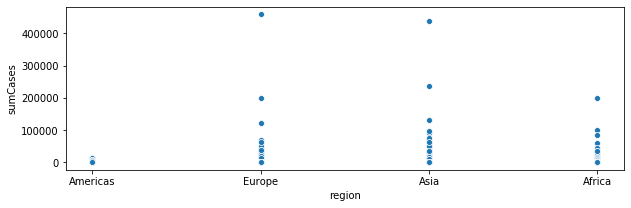

In [19]:

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['region'], y=outbreaks['sumCases'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumCases')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['disease'], y=outbreaks['sumAtRisk'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumAtRisk')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['localityQuality'], y=outbreaks['sumDeaths'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs sumDeaths')
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['observationDate'], y=outbreaks['humansAffected'])
scatterplot.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2018-01-01'))
plt.title('observationDate vs humansAffected')
plt.show()

## Diseases

In [1]:
top8_diseases.head()

plt.figure(figsize=(17,8))
box = sns.boxenplot(y='sumCases', x='disease', data=top8_diseases)
box.set_ylim(0, 1000)
plt.show()

top8_diseases.head()

NameError: name 'top8_diseases' is not defined

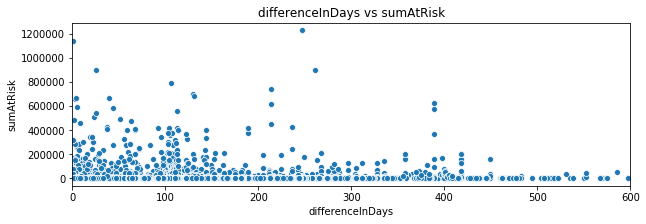

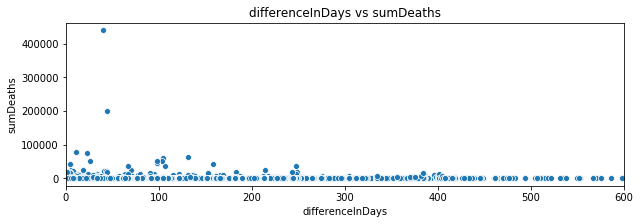

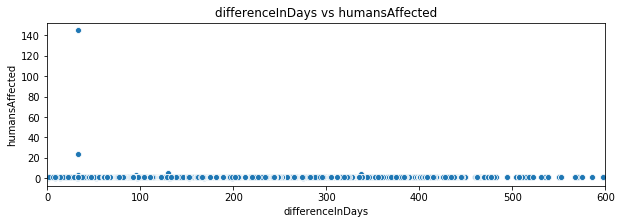

In [37]:

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumAtRisk'])
plt.title('differenceInDays vs sumAtRisk')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['sumDeaths'])
plt.title('differenceInDays vs sumDeaths')
scatterplot.set_xlim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
scatterplot = sns.scatterplot(x=outbreaks['differenceInDays'], y=outbreaks['humansAffected'])
plt.title('differenceInDays vs humansAffected')
scatterplot.set_xlim(0, 600)
plt.show()

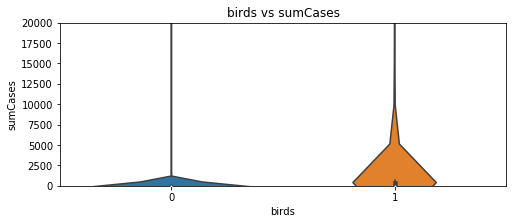

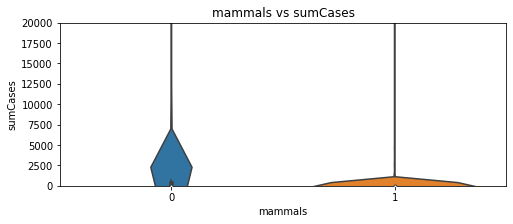

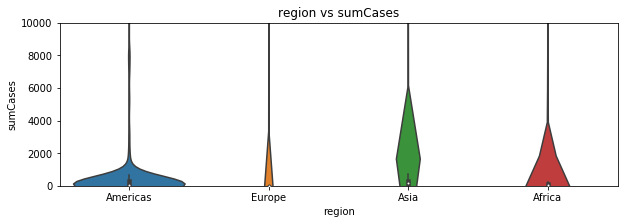

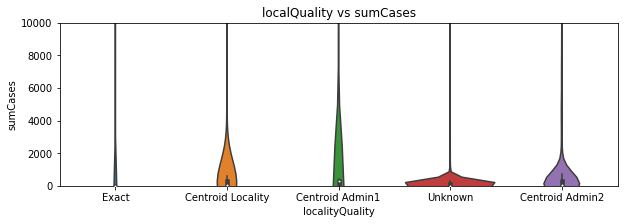

In [38]:
plt.figure(figsize=(8,3))
violinplot = sns.violinplot(x=outbreaks['birds'], y=outbreaks['sumCases'])
plt.title('birds vs sumCases')
violinplot.set_ylim(0, 20000)
plt.show()

plt.figure(figsize=(8,3))
violinplot = sns.violinplot(x=outbreaks['mammals'], y=outbreaks['sumCases'])
plt.title('mammals vs sumCases')
violinplot.set_ylim(0, 20000)
plt.show()

plt.figure(figsize=(10,3))
violinplot = sns.violinplot(x=outbreaks['region'], y=outbreaks['sumCases'])
plt.title('region vs sumCases')
violinplot.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
violinplot = sns.violinplot(x=outbreaks['localityQuality'], y=outbreaks['sumCases'])
plt.title('localQuality vs sumCases')
violinplot.set_ylim(0, 10000)
plt.show()


## Checking Normality and Standardizing Features

In [20]:
floats = ['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge', 'humansAffected', 
                 'humansDeaths', 'differenceInDays']
scaler = StandardScaler()

for feature in floats:
    col_name = str(feature+'_std')
    print(col_name)
    X[col_name] = scaler.fit_transform(X[feature].values.reshape(-1,1))

print('\n', X.columns)

sumAtRisk_std
sumCases_std
sumDeaths_std
sumDestroyed_std
sumSlaughtered_std
humansAge_std
humansAffected_std
humansDeaths_std
differenceInDays_std

 Index(['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansAffected', 'humansDeaths', 'humansAge', 'differenceInDays',
       'observationYear',
       ...
       'mammals', 'sumAtRisk_std', 'sumCases_std', 'sumDeaths_std',
       'sumDestroyed_std', 'sumSlaughtered_std', 'humansAge_std',
       'humansAffected_std', 'humansDeaths_std', 'differenceInDays_std'],
      dtype='object', length=281)


In [21]:
X.describe()

,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansAffected,humansDeaths,humansAge,differenceInDays,observationYear,observationMonth,observationDay,observationFirstHalfMonth,observationSecondHalfMonth,EC,FAO ECTAD RAF,FAO Field Officer,FAO officer,FAO-Report,International reference laboratory,Media,"National Institute for Communicable Diseases, NICD",National authorities,OIE,Other,UN Field Officer,WHO,sequence only,Africa,Americas,Asia,Europe,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Bhutan,Bosnia and Herzegovina,Botswana,Brazil,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Croatia,Cyprus,Czech Republic,Côte d'Ivoire,Dem People's Rep of Korea,Democratic Republic of the Congo,Denmark,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Finland,France,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Guinea,Guinea-Bissau,Honduras,"Hong Kong, SAR",Hungary,India,Indonesia,Iraq,Ireland,Israel,Italy,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libya,Lithuania,Luxembourg,Macau,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mayotte,Mexico,"Moldova, Republic of",Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Netherlands,Niger,Nigeria,Oman,Pakistan,Panama,Peru,Philippines,Poland,Portugal,Qatar,Republic of Korea,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Sierra Leone,Slovakia,Slovenia,South Africa,South Sudan,Spain,Sudan,Svalbard and Jan Mayen Islands,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Taiwan (Province of China),Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Tunisia,Turkey,U.K. of Great Britain and Northern Ireland,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,United States of America,Uruguay,Viet Nam,West Bank,Zambia,Zimbabwe,Centroid Admin1,Centroid Admin2,Centroid Locality,Exact,Unknown,Confirmed,Denied,African horse sickness,African swine fever,Anthrax,Bluetongue,Bovine spongiform encephalopathy,Bovine tuberculosis,Brucellosis (Brucella abortus),Brucellosis (Brucella melitensis),Brucellosis (Brucella suis),Classical swine fever,Contagious bovine pleuropneumonia,Equine infectious anaemia,Foot and mouth disease,Glanders,Influenza - Avian,Influenza - Equine,Lumpy skin disease,MERS-CoV,Newcastle disease,Peste des petits ruminants,Porcine reproductive and respiratory syndrome,Rabies,Rift Valley fever,Sheep pox and goat pox,West Nile Fever,1,16,19,2,22,3,4,5,7,8,"8, 4",A,"A, O",APMV-I,Asia 1,H3 LPAI,H3N1 LPAI,H3N8,H5 HPAI,H5 LPAI,H5N1 HPAI,H5N1 LPAI,"H5N1 LPAI, H5N2 LPAI",H5N2 HPAI,H5N2 LPAI,"H5N2 LPAI, H6N2 LPAI","H5N2 LPAI, H7N7 LPAI",H5N3 HPAI,H5N3 LPAI,"H5N3 LPAI, H5N2 LPAI",H5N5 HPAI,H5N5 LPAI,H5N6 HPAI,H5N6 LPAI,H5N8 HPAI,"H5N8 HPAI, H5N2 HPAI",H5N8 LPAI,H5N9 HPAI,H5N9 LPAI,H6N2 LPAI,H7 LPAI,H7N1 HPAI,H7N1 LPAI,H7N2 LPAI,H7N3 HPAI,H7N3 LPAI,H7N4 LPAI,H7N6 LPAI,H7N7 HPAI,H7N7 LPAI,H7N9 HPAI,H7N9 LPAI,H9N2 LPAI,HPAI,LPAI,Not Specified,Not specified,O,SAT1,SAT2,SAT3,Unknown Serotypes,wild,undomestic,domestic,captive,unspecified,birds,mammals,sumAtRisk_std,sumCases_std,sumDeaths_std,sumDestroyed_std,sumSlaughtered_std,humansAge_std,humansAffected_std,humansDeaths_std,differenceInDays_std
count,5.831000e+03,5831.000000,5831.000000,5.831000e+03,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.000000,5831.00000,5831.000000,5831.000000,5831.00000,5831.000000,5831.000000,5831.000000,5831.000000,5831.00000

In [22]:
features_to_test = X[['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
                      'humansAge', 'humansAffected', 'humansDeaths', 'differenceInDays']]
for feat in features_to_test:
    jb_stats = stats.jarque_bera(X[feat])
    norm_stats = stats.normaltest(X[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on sumAtRisk:
Jarque-Bera test statistics for sumAtRisk is 39516741.77269033 and p value is 0.0
Normality test statistics for sumAtRisk is 11690.474805080587 and p value is 0.0

Testing for normality on sumCases:
Jarque-Bera test statistics for sumCases is 160812336.51514748 and p value is 0.0
Normality test statistics for sumCases is 14031.28077725313 and p value is 0.0

Testing for normality on sumDeaths:
Jarque-Bera test statistics for sumDeaths is 754535466.9971347 and p value is 0.0
Normality test statistics for sumDeaths is 16330.434421734226 and p value is 0.0

Testing for normality on sumDestroyed:
Jarque-Bera test statistics for sumDestroyed is 161248090.7316045 and p value is 0.0
Normality test statistics for sumDestroyed is 14096.971838778398 and p value is 0.0

Testing for normality on sumSlaughtered:
Jarque-Bera test statistics for sumSlaughtered is 159713480.6743164 and p value is 0.0
Normality test statistics for sumSlaughtered is 14359.432780407365

In [26]:
standardized_features = X[['sumAtRisk_std', 'sumCases_std', 'sumDeaths_std', 'sumDestroyed_std', 'sumSlaughtered_std',
                      'humansAge_std', 'humansAffected_std', 'humansDeaths_std', 'differenceInDays_std']]
for feat in standardized_features:
    jb_stats = stats.jarque_bera(X[feat])
    norm_stats = stats.normaltest(X[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on sumAtRisk_std:
Jarque-Bera test statistics for sumAtRisk_std is 39516741.772690356 and p value is 0.0
Normality test statistics for sumAtRisk_std is 11690.47480508059 and p value is 0.0

Testing for normality on sumCases_std:
Jarque-Bera test statistics for sumCases_std is 160812336.51514757 and p value is 0.0
Normality test statistics for sumCases_std is 14031.28077725313 and p value is 0.0

Testing for normality on sumDeaths_std:
Jarque-Bera test statistics for sumDeaths_std is 754535466.997134 and p value is 0.0
Normality test statistics for sumDeaths_std is 16330.434421734226 and p value is 0.0

Testing for normality on sumDestroyed_std:
Jarque-Bera test statistics for sumDestroyed_std is 161248090.7316044 and p value is 0.0
Normality test statistics for sumDestroyed_std is 14096.971838778394 and p value is 0.0

Testing for normality on sumSlaughtered_std:
Jarque-Bera test statistics for sumSlaughtered_std is 159713480.6743164 and p value is 0.0
Normality t

In [27]:
corr_mat = X.corr().loc[:, ['humansDeaths_std']].abs().sort_values(by='humansDeaths_std', ascending=False)
pd.set_option('display.max_rows', None)
corr_mat[:70]

,humansDeaths_std
humansDeaths,1.000000
humansDeaths_std,1.000000
humansAffected,0.946065
humansAffected_std,0.946065
sumAtRisk,0.344606
sumAtRisk_std,0.344606
Poland,0.329941
Europe,0.225870
African swine fever,0.217183
Romania,0.203732


# Dimensionality Reduction

## PCA

In [23]:
# PCA with all variables

X_all = X.drop(columns = ['sumAtRisk', 'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered', 'humansAge', 'humansAffected', 
                 'humansDeaths', 'differenceInDays'])
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
print(pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80= pca_80.fit_transform(X_all)
print(pca_80.explained_variance_ratio_)

[0.7293021  0.12424868]
[0.7293021  0.12424868]


Cluster Graph with PCA 


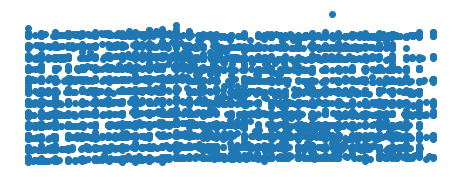

In [24]:
print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

First two PCA components:  [0.88685613 0.03032601]
PCA components for 80% of variance:  [0.88685613]
Cluster Graph with PCA 


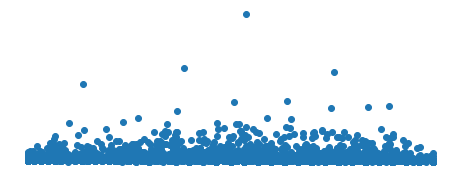

In [25]:
# PCA for features with greater than 0.01 absolute correlation with potential target

X_hd = X[['humansDeaths_std', 'humansAffected_std','sumAtRisk_std', 'Poland','Europe','sumDestroyed_std',
          'African swine fever','Romania', '8', 'France','wild', 'domestic','Bluetongue', 'birds','Africa',
                  'mammals','Asia','sumSlaughtered_std', 'Foot and mouth disease','H5N3 HPAI', 'unspecified',
          'Influenza - Avian', 'Albania','H7N9 LPAI','Americas','Unknown Serotypes','Newcastle disease',
          'O','4', 'Serbia','Israel','Latvia', 'H5N1 HPAI', 'observationFirstHalfMonth',
        'Anthrax','Sheep pox and goat pox','Mongolia','H5N8 HPAI','West Nile Fever','observationDay', 'South Africa',
        'OIE','Lumpy skin disease', 'Greece','Ukraine','H5N2 LPAI','Centroid Locality','Rabies','SAT2',
         'Taiwan (Province of China)', 'FAO Field Officer','Namibia', 'Zimbabwe', 'Belgium','sumCases_std']]


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
print('First two PCA components: ', pca.explained_variance_ratio_)

pca_80 = PCA(n_components=0.80)
pca_components_80 = pca_80.fit_transform(X_hd)
print('PCA components for 80% of variance: ', pca_80.explained_variance_ratio_)


print('Cluster Graph with PCA ')
plt.figure(figsize=(8,3))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## t-SNE

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.472s...
[t-SNE] Computed neighbors for 5831 samples in 7.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.156814
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.226097
[t-SNE] KL divergence after 300 iterations: 3.039212
Cluster Graph with t-SNE with Perplexity  10


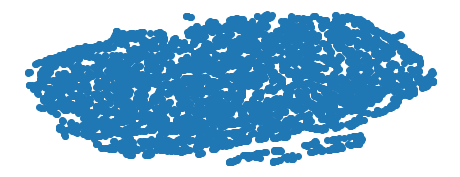

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.629s...
[t-SNE] Computed neighbors for 5831 samples in 8.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.322864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.855316
[t-SNE] KL divergence after 300 iterations: 2.644083
Cluster Graph with t-SNE with Perplexity  20


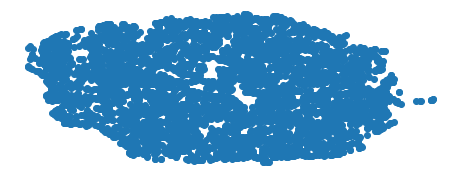

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.502s...
[t-SNE] Computed neighbors for 5831 samples in 9.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.414848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.254562
[t-SNE] KL divergence after 300 iterations: 2.392616
Cluster Graph with t-SNE with Perplexity  30


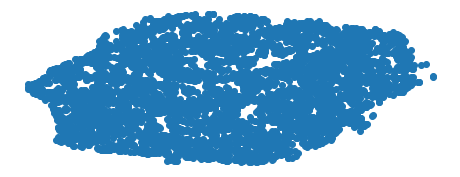

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.472s...
[t-SNE] Computed neighbors for 5831 samples in 8.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.480690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.278786
[t-SNE] KL divergence after 300 iterations: 2.253987
Cluster Graph with t-SNE with Perplexity  40


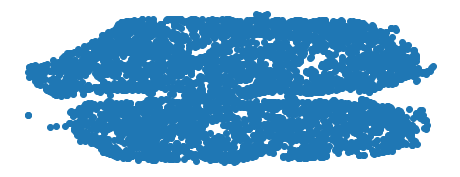

In [48]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_all)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.136s...
[t-SNE] Computed neighbors for 5831 samples in 1.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 0.007200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.193405
[t-SNE] KL divergence after 300 iterations: 2.704752
Cluster Graph with t-SNE with Perplexity  10


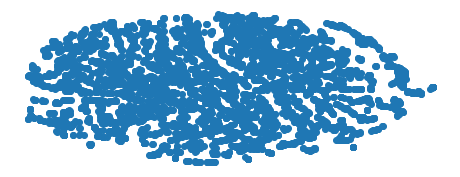

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.195s...
[t-SNE] Computed neighbors for 5831 samples in 3.191s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 0.868273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.123611
[t-SNE] KL divergence after 300 iterations: 2.316576
Cluster Graph with t-SNE with Perplexity  20


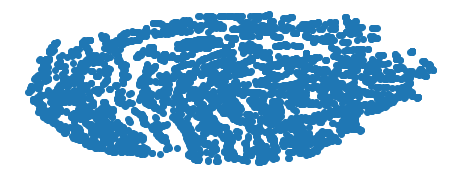

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.184s...
[t-SNE] Computed neighbors for 5831 samples in 3.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.031261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.068794
[t-SNE] KL divergence after 300 iterations: 2.135123
Cluster Graph with t-SNE with Perplexity  30


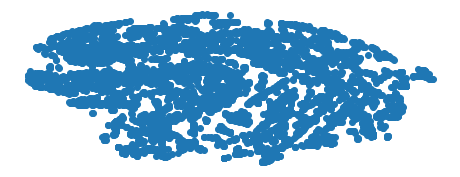

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5831 samples in 0.197s...
[t-SNE] Computed neighbors for 5831 samples in 2.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5831
[t-SNE] Computed conditional probabilities for sample 2000 / 5831
[t-SNE] Computed conditional probabilities for sample 3000 / 5831
[t-SNE] Computed conditional probabilities for sample 4000 / 5831
[t-SNE] Computed conditional probabilities for sample 5000 / 5831
[t-SNE] Computed conditional probabilities for sample 5831 / 5831
[t-SNE] Mean sigma: 1.099010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.363525
[t-SNE] KL divergence after 300 iterations: 1.969158
Cluster Graph with t-SNE with Perplexity  40


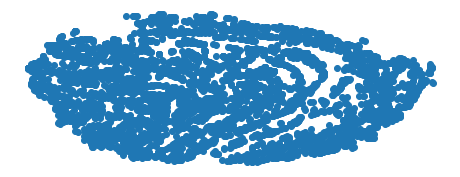

In [89]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X_hd)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)
    plt.figure(figsize=(8,3))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

## UMAP

In [70]:
!!pip install --upgrade umap-learn==0.3.10

['Requirement already up-to-date: umap-learn==0.3.10 in c:\\users\\m246047\\appdata\\local\\continuum\\miniconda3\\lib\\site-packages (0.3.10)',
 'Requirement already satisfied, skipping upgrade: numba>=0.37 in c:\\users\\m246047\\appdata\\local\\continuum\\miniconda3\\lib\\site-packages (from umap-learn==0.3.10) (0.46.0)',
 'Requirement already satisfied, skipping upgrade: numpy>=1.13 in c:\\users\\m246047\\appdata\\local\\continuum\\miniconda3\\lib\\site-packages (from umap-learn==0.3.10) (1.16.4)',
 'Requirement already satisfied, skipping upgrade: scikit-learn>=0.16 in c:\\users\\m246047\\appdata\\local\\continuum\\miniconda3\\lib\\site-packages (from umap-learn==0.3.10) (0.22)',
 'Requirement already satisfied, skipping upgrade: scipy>=0.19 in c:\\users\\m246047\\appdata\\local\\continuum\\miniconda3\\lib\\site-packages (from umap-learn==0.3.10) (1.3.0)',
 'Requirement already satisfied, skipping upgrade: llvmlite>=0.30.0dev0 in c:\\users\\m246047\\appdata\\local\\continuum\\minic

In [75]:
import umap.umap_ as umap

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [73]:
# UMAP with all features
print('UMAP with all features. \n')
for n_neighbors in [50, 100, 250]:
    for min_dist in [0.5, 0.75, 1]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').f
        
        
        print('UMAP for X_all with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

UMAP with all features. 



AttributeError: module 'umap' has no attribute 'UMAP'

In [46]:
import operator

def get_pvalue_2clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        t, pvalue = stats.ttest_ind(group_0[[variable]], group_1[[variable]])
        variables_pvalues[variable] = pvalue
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)

def get_pvalue_3clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        stat, pvalue = stats.f_oneway(group_0[[variable]], group_1[[variable]], group_2[[variable]])
        signature_pvalues[variable] = pvalue
        print(variable, ':', stat, pvalue)
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)

# Clustering

I'll use K-Means, DBSCAN, Agglomerative, and GMM clustering techniques. 

## K-Means with PCA

Best Silhouette score is 0.5206255354873454 with 2 clusters. 
Best Davies Bouldin score:  0.696920613480739

In [33]:
# Get a list of keys from dictionary which has the given value

def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

47.2 ms ± 6.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
94 ms ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
150 ms ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
191 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
231 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
224 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
262 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
296 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
310 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
361 ms ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
518 ms ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


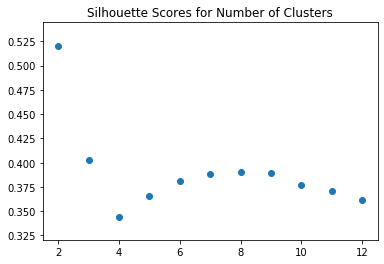

Best Silhouette score is 0.3612974150635148 with 12 clusters. 
Best Davies Bouldin score:  0.6969206134807383


TypeError: '<' not supported between instances of 'int' and 'list'

In [36]:
def kmeans_clustering(df, dr_technique):
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    silhouettes_list = []
    silhouettes_dict = {} # silhoutte scores are keys, clusters are values
    dbs = []       
        
    
    if dr_technique==PCA:
        pca = PCA(n_components=2)
        components = pca.fit_transform(df)
        
    elif dr_technique==UMAP:
        if df==X_all:
            neighbors = 50
        elif df==X_hd:
            neighbors = 50           
        components = umap.UMAP(n_neighbors=neighbors, min_dist=0.1, metric='correlation').fit_transform(df)
        
    # looping through cluster numbers to find the best cluster
    for cluster in clusters:
        labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(components)
        kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
        %timeit kmeans_cluster.fit(components)
        y_pred = kmeans_cluster.predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_list.append(silhouette)
        silhouettes_dict[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)

    # plotting the silhouette scores
    plt.title('Silhouette Scores for Number of Clusters')  
    plt.scatter(list(silhouettes_dict.keys()), list(silhouettes_dict.values()))
    plt.show()

    print('Best Silhouette score is {} with {} clusters. '.format(silhouettes_dict[max(silhouettes_dict.keys())], max(silhouettes_dict.keys())))
    print('Best Davies Bouldin score: ', min(dbs))
        
        # plotting the clusters with the best silhouette score
    best_cluster = getKeysByValue(silhouettes_dict, max(silhouettes_list))
    labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(components)
    kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
    %timeit kmeans_cluster.fit(components)
    y_pred = kmeans_cluster.predict(components)
        
    plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_dict[max(silhouettes_dict.keys())]))
    plt.scatter(components[:,0], components[:,1], c=y_pred)
    plt.show()
        
kmeans_clustering(X_all, PCA)

43 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


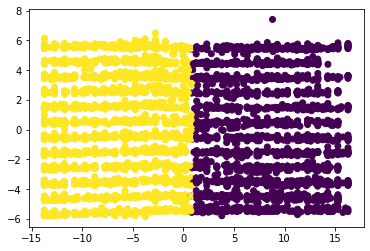

In [42]:
best_cluster
labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(components)
kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
%timeit kmeans_cluster.fit(components)
y_pred = kmeans_cluster.predict(components)

# plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_dict[max(silhouettes_dict.keys())]))
plt.scatter(components[:,0], components[:,1], c=y_pred)
plt.show()

66 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 ms ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
194 ms ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
219 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
298 ms ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
304 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
352 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
358 ms ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
314 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
358 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
557 ms ± 74.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


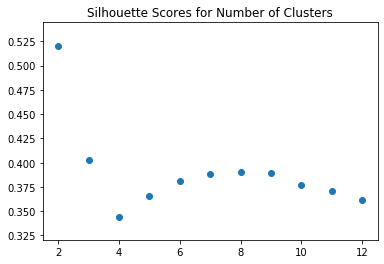

Best Silhouette score is 0.5206255354873454 with 2 clusters. 
Best Davies Bouldin score:  0.696920613480739
62.8 ms ± 9.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


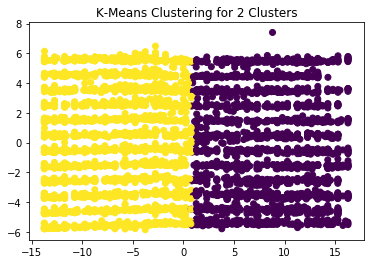

{2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1}


NameError: name 'cluster_labels' is not defined

In [78]:
# K-means with all variables

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouettes_kpca = []
silhouettes_kpca_dict = {} # silhoutte scores are keys, clusters are values
dbs_kpca = []

# looping through cluster numbers to find the best cluster
for cluster in clusters:
    
    labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean')
    silhouettes_kpca.append(silhouette)
    silhouettes_kpca_dict[silhouette] = cluster
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs_kpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_kpca_dict.values()), list(silhouettes_kpca_dict.keys()))
plt.show()


print('Best Silhouette score is {} with {} clusters. '.format(max(silhouettes_kpca_dict.keys()), silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
print('Best Davies Bouldin score: ', min(dbs_kpca))

# plotting the clusters with the best silhouette score
best_cluster = silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]
labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)

plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_pca_clusters'] = labels

In [47]:
# K-means with all variables

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(pca_components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_pca_clusters'] = labels
group_0 = X[X['X_pca_clusters'] == 0]
group_1 = X[X['X_pca_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 284)
5831
{0: 2607, 1: 3224}
observationDay : [0.]
observationFirstHalfMonth : [0.]
observationSecondHalfMonth : [0.]
X_hd_pca_agg_clusters : [0.]
X_hd_pca_gmm_clusters : [0.]
X_pca_clusters : [0.]
differenceInDays : [2.66320731e-12]
differenceInDays_std : [2.66320731e-12]
humansAffected_std : [5.79432711e-06]
humansAffected : [5.79432711e-06]
humansDeaths : [7.4344392e-06]
humansDeaths_std : [7.4344392e-06]
Burkina Faso : [0.00323522]
sumAtRisk_std : [0.00589839]
sumAtRisk : [0.00589839]
sumCases : [0.00704516]
sumCases_std : [0.00704516]
Taiwan (Province of China) : [0.00788313]
H5N8 HPAI : [0.00858584]
EC : [0.01721676]
H5N2 HPAI : [0.01767926]
sumDeaths_std : [0.03104556]
sumDeaths : [0.03104556]
Equine infectious anaemia : [0.03393137]
HPAI : [0.03606911]
Panama : [0.05403844]
National Institute for Communicable Diseases, NICD : [0.06147955]
Swaziland : [0.06673567]
Gaza Strip : [0.07202654]
Syrian Arab Republic : [0.07202654]
United Republic of Tanzania : [0.07202654]
Afri

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


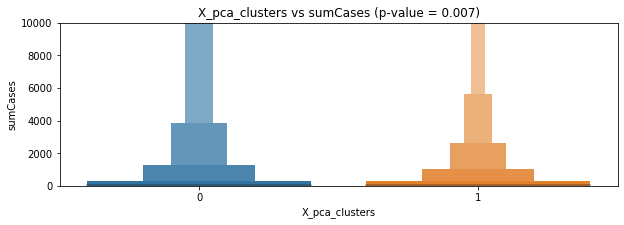

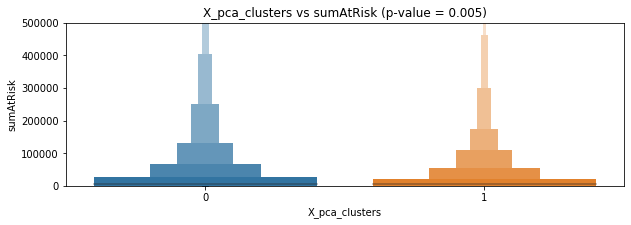

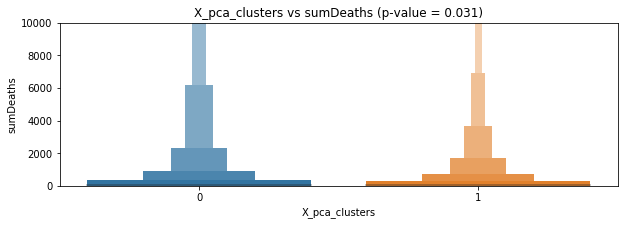

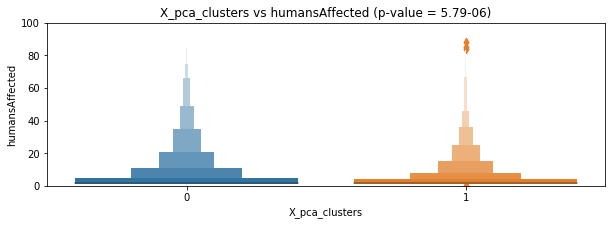

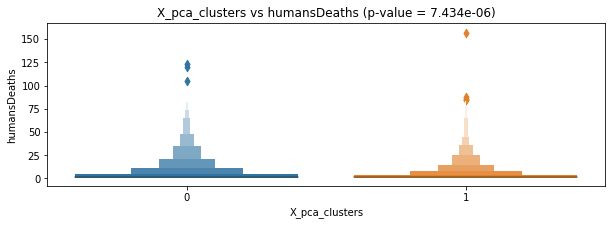

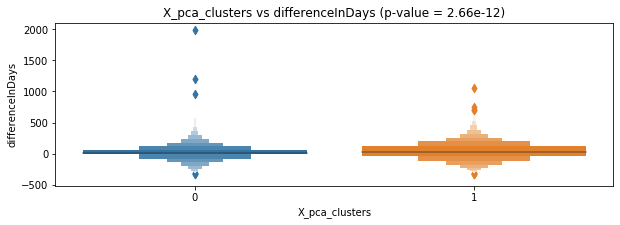

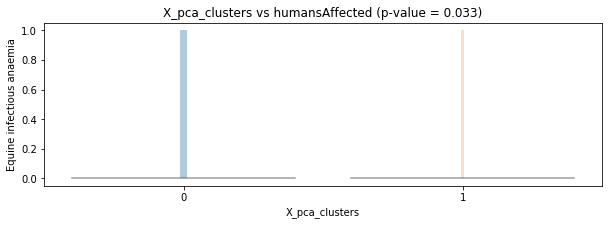

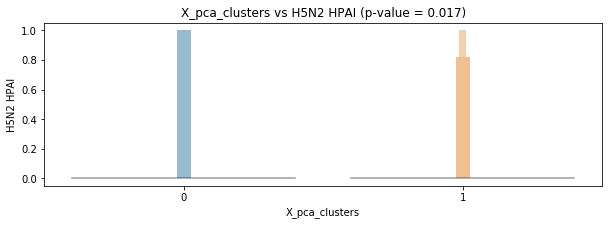

In [138]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_pca_clusters'], y=X['sumCases'])
plt.title('X_pca_clusters vs sumCases (p-value = 0.007)')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_pca_clusters'], y=X['sumAtRisk'])
plt.title('X_pca_clusters vs sumAtRisk (p-value = 0.005)')
box.set_ylim(0, 500000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_pca_clusters'], y=X['sumDeaths'])
plt.title('X_pca_clusters vs sumDeaths (p-value = 0.031)')
box.set_ylim(0, 10000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_pca_clusters'], y=X['humansAffected'])
plt.title('X_pca_clusters vs humansAffected (p-value = 5.79-06)')
box.set_ylim(0, 100)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_pca_clusters'], y=X['humansDeaths'])
plt.title('X_pca_clusters vs humansDeaths (p-value = 7.434e-06)')
# scatterplot.set_xlim(0, 600)
plt.show()


plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_pca_clusters'], y=X['differenceInDays'])
plt.title('X_pca_clusters vs differenceInDays (p-value = 2.66e-12)')
# scatterplot.set_xlim(0, 600)
plt.show()


plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_pca_clusters'], y=X['Equine infectious anaemia'])
plt.title('X_pca_clusters vs Equine infectious anaemia (p-value = 0.033)')
# scatterplot.set_xlim(0, 600)
plt.show()


plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_pca_clusters'], y=X['H5N2 HPAI'])
plt.title('X_pca_clusters vs H5N2 HPAI (p-value = 0.017)')
# scatterplot.set_xlim(0, 600)
plt.show()

## K-Means with features highly correlated with humansDeaths

Best Silhouette score is 0.610064216395963 with 2 clusters. 
Best Davies Bouldin score:  0.529448786405637

65.8 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
141 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
156 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
200 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
220 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
239 ms ± 7.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
294 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
328 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
354 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
349 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
551 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


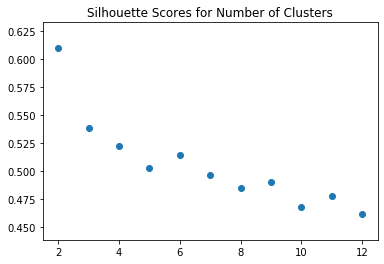

Best Silhouette score is 0.610064216395963 with 2 clusters. 
Best Davies Bouldin score:  0.529448786405637
81.9 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


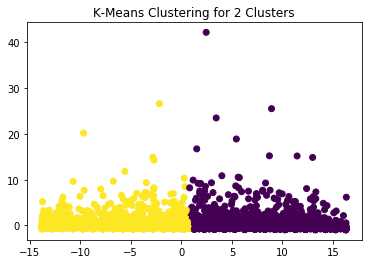

In [27]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouettes_kpca = []
silhouettes_kpca_dict = {} # silhoutte scores are keys, clusters are values
dbs_kpca = []

# looping through cluster numbers to find the best cluster
for cluster in clusters:
    
    labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(pca_components)
    kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
    %timeit kmeans_cluster.fit(pca_components)
    y_pred = kmeans_cluster.predict(pca_components)
    silhouette = metrics.silhouette_score(pca_components, labels, metric='euclidean', sample_size=5000)
    silhouettes_kpca.append(silhouette)
    silhouettes_kpca_dict[silhouette] = cluster
    db = metrics.davies_bouldin_score(pca_components, labels)
    dbs_kpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_kpca_dict.values()), list(silhouettes_kpca_dict.keys()))
plt.show()


print('Best Silhouette score is {} with {} clusters. '.format(max(silhouettes_kpca_dict.keys()), silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
print('Best Davies Bouldin score: ', min(dbs_kpca))

# plotting the clusters with the best silhouette score
best_cluster = silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]
labels = KMeans(n_clusters=best_cluster, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=best_cluster, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)

plt.title('K-Means Clustering for {} Clusters'.format(silhouettes_kpca_dict[max(silhouettes_kpca_dict.keys())]))
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

120 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


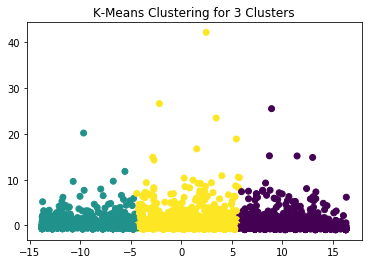

105 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


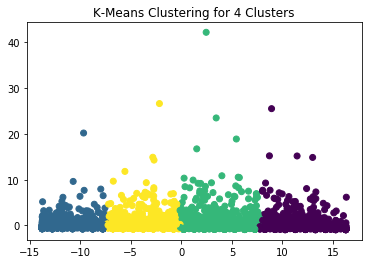

In [90]:
# Graph for three clusters
labels = KMeans(n_clusters=3, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=3, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)
plt.title('K-Means Clustering for 3 Clusters')
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

# Graph for four clusters
labels = KMeans(n_clusters=4, random_state=123).fit_predict(pca_components)
kmeans_cluster = KMeans(n_clusters=4, random_state=123)
%timeit kmeans_cluster.fit(pca_components)
y_pred = kmeans_cluster.predict(pca_components)
plt.title('K-Means Clustering for 4 Clusters')
plt.scatter(pca_components[:,0], pca_components[:,1], c=y_pred)
plt.show()

In [159]:
# K-means with all variables

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(pca_components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_pca_clusters'] = labels
group_0 = X[X['X_hd_pca_clusters'] == 0]
group_1 = X[X['X_hd_pca_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 281)
5831
{0: 2603, 1: 3228}
sumAtRisk : [2.7487218] [0.00600124]
sumCases : [2.70874004] [0.00677365]
sumDeaths : [2.1692001] [0.03010778]
sumDestroyed : [1.6174729] [0.10583035]
sumSlaughtered : [0.34323491] [0.73143412]
humansAffected : [4.50459768] [6.77964082e-06]
humansDeaths : [4.44893462] [8.79023977e-06]
humansAge : [-0.05020643] [0.95995961]
differenceInDays : [-7.04420405] [2.08048594e-12]
observationYear : [0.59205008] [0.55384002]
observationMonth : [1.02618839] [0.30484537]
observationDay : [131.53316976] [0.]
observationFirstHalfMonth : [-325.308725] [0.]
observationSecondHalfMonth : [325.308725] [0.]
EC : [2.39055881] [0.01685431]
FAO ECTAD RAF : [-0.89797265] [0.36923722]
FAO Field Officer : [0.75734905] [0.44887138]
FAO officer : [-1.00859275] [0.31321185]
FAO-Report : [-0.89797265] [0.36923722]
International reference laboratory : [0.20102466] [0.84068631]
Media : [1.11362411] [0.2654864]
National Institute for Communicable Diseases, NICD : [1.87299045] [0.061

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


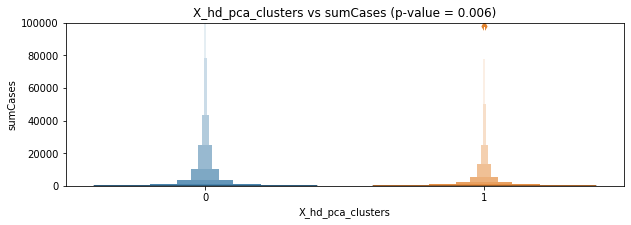

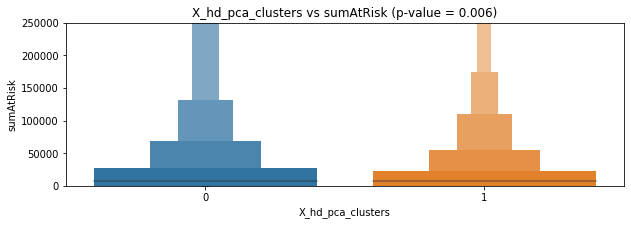

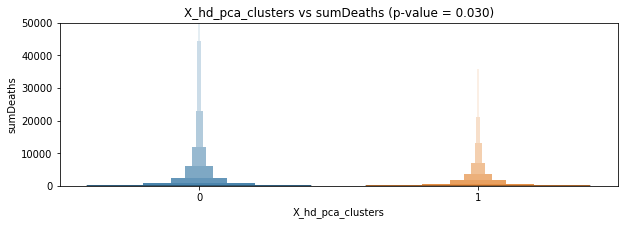

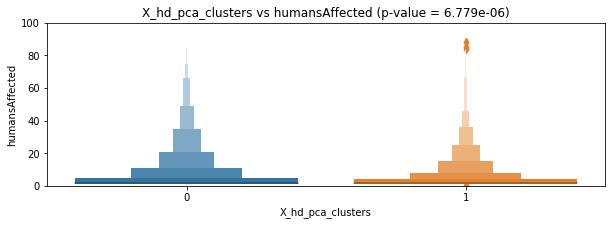

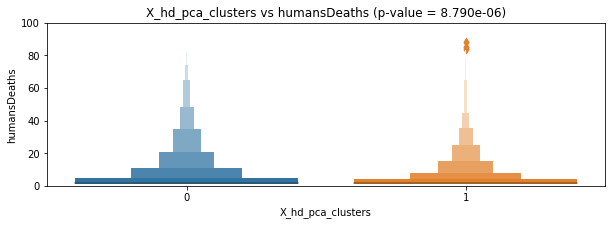

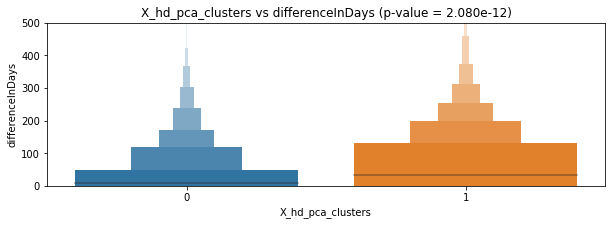

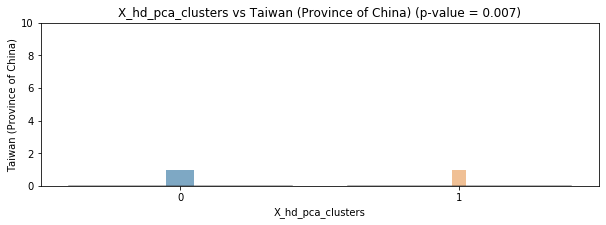

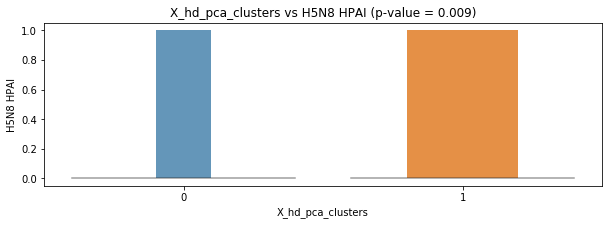

In [167]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['sumCases'])
plt.title('X_hd_pca_clusters vs sumCases (p-value = 0.006)')
box.set_ylim(0, 100000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['sumAtRisk'])
plt.title('X_hd_pca_clusters vs sumAtRisk (p-value = 0.006)')
box.set_ylim(0, 250000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['sumDeaths'])
plt.title('X_hd_pca_clusters vs sumDeaths (p-value = 0.030)')
box.set_ylim(0, 50000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['humansAffected'])
plt.title('X_hd_pca_clusters vs humansAffected (p-value = 6.779e-06)')
box.set_ylim(0, 100)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['humansDeaths'])
plt.title('X_hd_pca_clusters vs humansDeaths (p-value = 8.790e-06)')
box.set_ylim(0, 100)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['differenceInDays'])
plt.title('X_hd_pca_clusters vs differenceInDays (p-value = 2.080e-12)')
box.set_ylim(0, 500)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['Taiwan (Province of China)'])
plt.title('X_hd_pca_clusters vs Taiwan (Province of China) (p-value = 0.007)')
box.set_ylim(0, 10)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_hd_pca_clusters'], y=X['H5N8 HPAI'])
plt.title('X_hd_pca_clusters vs H5N8 HPAI (p-value = 0.009)')
# scatterplot.set_ylim(0, 600)
plt.show()

## Agglomerative with PCA

Best Silhouette score with ward linkage is 0.5047047122113972 with 2 clusters. 
Best Silhouette score with complete linkage is 0.4816389604424055 with 2 clusters. 
Best Silhouette score with average linkage is 0.4795326314092059 with 2 clusters. 
Best Davies Bouldin score:  0.6870631034046115

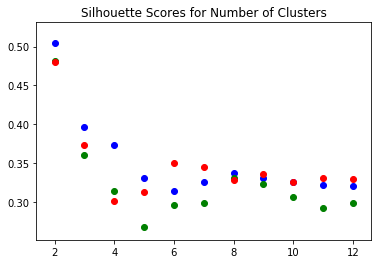

Best Silhouette score with ward linkage is 0.5047047122113972 with 2 clusters. 
Best Silhouette score with complete linkage is 0.4816389604424055 with 2 clusters. 
Best Silhouette score with average linkage is 0.4795326314092059 with 2 clusters. 
Best Davies Bouldin score:  0.6870631034046115


In [168]:
# With PCA components from all features
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

dbs_aggpca = []
linkage_types = ['ward', 'complete', 'average']


# looping through cluster numbers to find the best cluster
silhouettes_aggpca_ward = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_ward[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_complete = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_complete[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_average = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_average[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_aggpca_ward.values()), list(silhouettes_aggpca_ward.keys()), color='blue')
plt.scatter(list(silhouettes_aggpca_complete.values()), list(silhouettes_aggpca_complete.keys()), color='green')
plt.scatter(list(silhouettes_aggpca_average.values()), list(silhouettes_aggpca_average.keys()), color='red')
plt.show()


print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_ward.keys()), silhouettes_aggpca_ward[max(silhouettes_aggpca_ward.keys())]))
print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_complete.keys()), silhouettes_aggpca_complete[max(silhouettes_aggpca_complete.keys())]))
print('Best Silhouette score with average linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_average.keys()), silhouettes_aggpca_average[max(silhouettes_aggpca_average.keys())]))
print('Best Davies Bouldin score: ', min(dbs_aggpca))

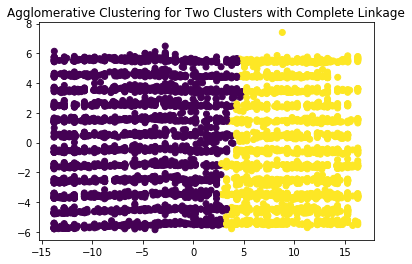

Silhouette Score:  0.5047047122113972
Davies Bouldin Index:  0.6870631034046115


In [169]:
# plotting the clusters with the best silhouette score

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
cluster_labels = agg_cluster.fit_predict(pca_components)

plt.title('Agglomerative Clustering for Two Clusters with Complete Linkage')
plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

## Agglomerative Clustering with Features Highly Correlated with humansDeaths

Best Silhouette score with ward linkage is 0.5986642423793109 with 2 clusters. 

Best Silhouette score with complete linkage is 0.6079834112247939 with 4 clusters. 

Best Silhouette score with average linkage is 0.7626181225674764 with 2 clusters.  This assigns one data point separately.

Best Davies Bouldin score:  0.18036479524944146

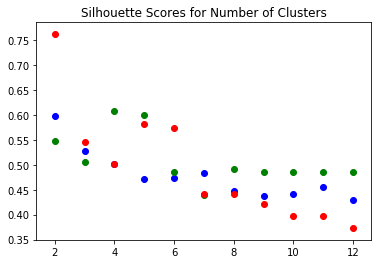

Best Silhouette score with ward linkage is 0.5986642423793109 with 2 clusters. 
Best Silhouette score with complete linkage is 0.6079834112247939 with 4 clusters. 
Best Silhouette score with average linkage is 0.7626181225674764 with 2 clusters. 
Best Davies Bouldin score:  0.18036479524944146


In [170]:
# With PCA components from features with greater than 0.01 correlation
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


silhouettes_aggpca_complete = {} # silhoutte scores are keys, clusters are values
silhouettes_aggpca_average = {} # silhoutte scores are keys, clusters are values
dbs_aggpca = []
linkage_types = ['ward', 'complete', 'average']


# looping through cluster numbers to find the best cluster
silhouettes_aggpca_ward = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_ward[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_complete = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_complete[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_average = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_average[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_aggpca_ward.values()), list(silhouettes_aggpca_ward.keys()), color='blue')
plt.scatter(list(silhouettes_aggpca_complete.values()), list(silhouettes_aggpca_complete.keys()), color='green')
plt.scatter(list(silhouettes_aggpca_average.values()), list(silhouettes_aggpca_average.keys()), color='red')
plt.show()


print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_ward.keys()), silhouettes_aggpca_ward[max(silhouettes_aggpca_ward.keys())]))
print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_complete.keys()), silhouettes_aggpca_complete[max(silhouettes_aggpca_complete.keys())]))
print('Best Silhouette score with average linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_average.keys()), silhouettes_aggpca_average[max(silhouettes_aggpca_average.keys())]))
print('Best Davies Bouldin score: ', min(dbs_aggpca))




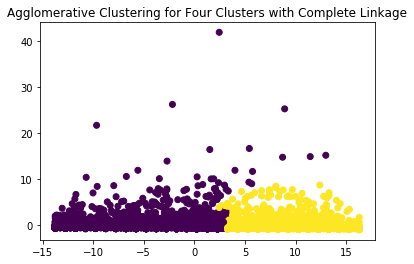

Silhouette Score:  0.5986642423790256
Davies Bouldin Index:  0.518706117773626


In [178]:
# plotting the clusters with the best silhouette score

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
cluster_labels = agg_cluster.fit_predict(pca_components)

plt.title('Agglomerative Clustering for Four Clusters with Complete Linkage')
plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
plt.show()

print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

In [179]:
# K-means with all variables

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

labels = AgglomerativeClustering(linkage='ward', n_clusters=2, affinity='euclidean').fit_predict(pca_components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_pca_agg_clusters'] = labels
group_0 = X[X['X_hd_pca_agg_clusters'] == 0]
group_1 = X[X['X_hd_pca_agg_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 283)
5831
{0: 3610, 1: 2221}
sumAtRisk : [1.85337231] [0.06387951]
sumCases : [-0.85194082] [0.39428194]
sumDeaths : [0.35365374] [0.72361119]
sumDestroyed : [2.28071362] [0.02260133]
sumSlaughtered : [-0.41653158] [0.6770364]
humansAffected : [-0.33444365] [0.73805684]
humansDeaths : [-0.64132784] [0.52133492]
humansAge : [0.5109415] [0.60941137]
differenceInDays : [6.70718721] [2.17131936e-11]
observationYear : [-0.11585612] [0.90777057]
observationMonth : [-0.57899097] [0.56261764]
observationDay : [-124.9372241] [0.]
observationFirstHalfMonth : [150.27501395] [0.]
observationSecondHalfMonth : [-150.27501395] [0.]
EC : [-2.75738315] [0.00584475]
FAO ECTAD RAF : [0.78434358] [0.43287041]
FAO Field Officer : [-1.00498479] [0.31494589]
FAO officer : [1.18881764] [0.23455986]
FAO-Report : [0.78434358] [0.43287041]
International reference laboratory : [-0.08922018] [0.92890999]
Media : [-1.27497779] [0.20236792]
National Institute for Communicable Diseases, NICD : [-1.42699624] [0

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


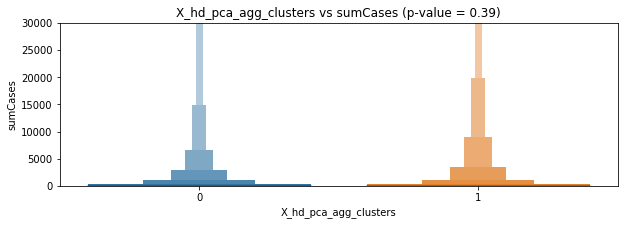

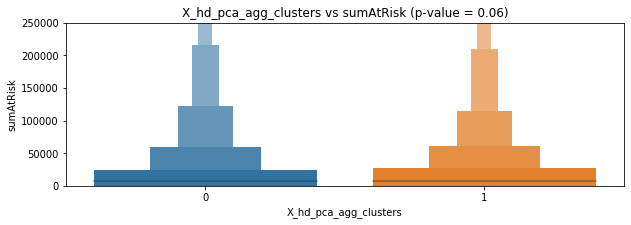

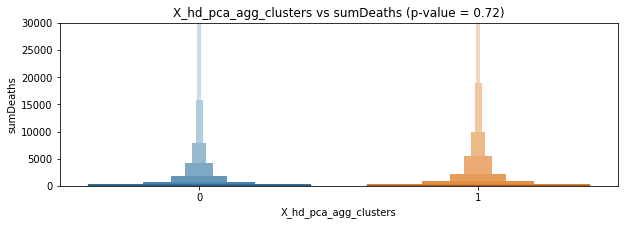

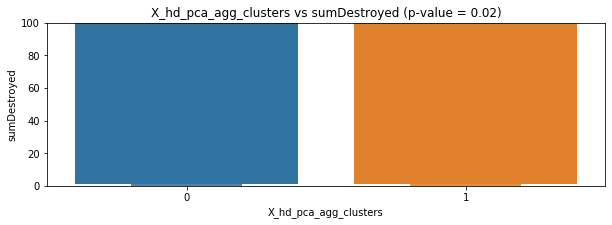

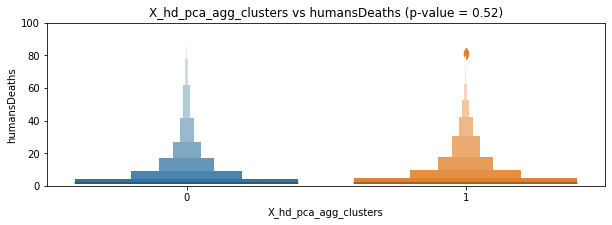

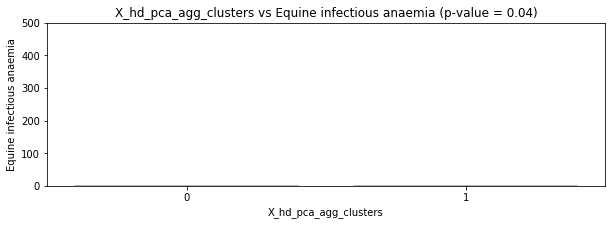

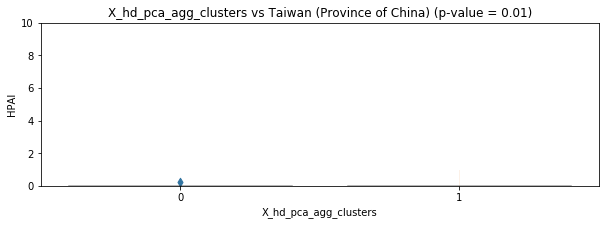

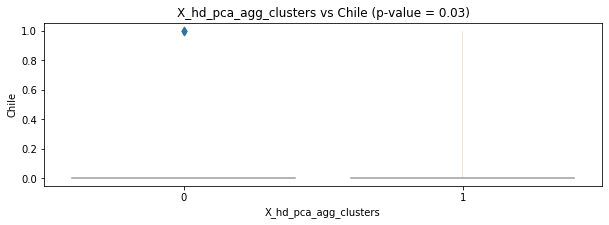

In [181]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['sumCases'])
plt.title('X_hd_pca_agg_clusters vs sumCases (p-value = 0.39)')
box.set_ylim(0, 30000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['sumAtRisk'])
plt.title('X_hd_pca_agg_clusters vs sumAtRisk (p-value = 0.06)')
box.set_ylim(0, 250000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['sumDeaths'])
plt.title('X_hd_pca_agg_clusters vs sumDeaths (p-value = 0.72)')
box.set_ylim(0, 30000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['sumDestroyed'])
plt.title('X_hd_pca_agg_clusters vs sumDestroyed (p-value = 0.02)')
box.set_ylim(0, 100)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['humansDeaths'])
plt.title('X_hd_pca_agg_clusters vs humansDeaths (p-value = 0.52)')
box.set_ylim(0, 100)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['Equine infectious anaemia'])
plt.title('X_hd_pca_agg_clusters vs Equine infectious anaemia (p-value = 0.04)')
box.set_ylim(0, 500)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['HPAI'])
plt.title('X_hd_pca_agg_clusters vs Taiwan (Province of China) (p-value = 0.01)')
box.set_ylim(0, 10)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_hd_pca_agg_clusters'], y=X['Chile'])
plt.title('X_hd_pca_agg_clusters vs Chile (p-value = 0.03)')
# scatterplot.set_ylim(0, 600)
plt.show()

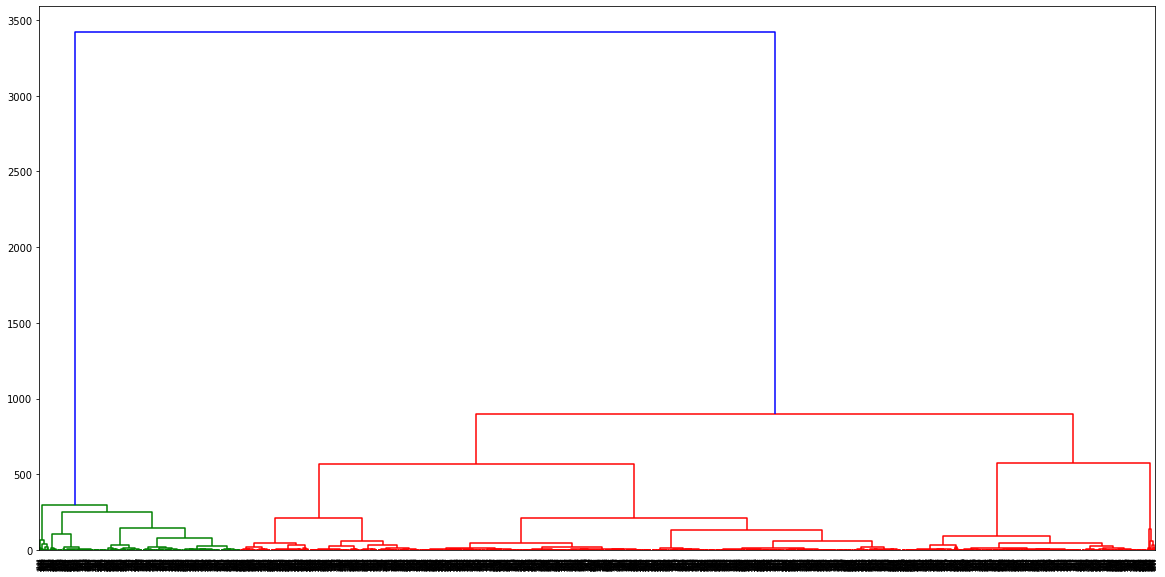

In [110]:
X_01_agg = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear',  'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=1)
pca_components = pca.fit_transform(X_01_agg)
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

plt.figure(figsize=(20,10))
dendrogram(lnkg(pca_components, method='ward'))
plt.show()

## DBSCAN with Features Highly Correlated with humansDeaths

In [41]:
def dbscan_find_clusters(eps, min_samples, X):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_dbscan = {}
    if num_labels == 1 or num_labels == num_samples:
          silhouette = -1
          silhouettes_dbscan[silhouette] = min_samples
          print('{} min samples and {} eps have no clusters.'.format(min_samples, eps))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          print('{} min samples and {} eps have {} silhouette score.'.format(min_samples, eps, silhouette))
          return {
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = min_samples
    plt.title('Silhouette Scores for {} eps'.format(eps))
    plt.scatter(list(silhouettes_dbscan.values()), list(silhouettes_dbscan.keys()), color='blue')
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score') 

2 min samples and 0.01 eps have -0.47170531672607724 silhouette score.
3 min samples and 0.01 eps have -0.6869466306965292 silhouette score.
4 min samples and 0.01 eps have -0.7687629654045542 silhouette score.
5 min samples and 0.01 eps have -0.7173170748776544 silhouette score.
6 min samples and 0.01 eps have -0.5844663183331779 silhouette score.
10 min samples and 0.01 eps have no clusters.
15 min samples and 0.01 eps have no clusters.
2 min samples and 0.5 eps have -0.43185984804432825 silhouette score.
3 min samples and 0.5 eps have -0.4026725342240872 silhouette score.
4 min samples and 0.5 eps have -0.38446807826419394 silhouette score.
5 min samples and 0.5 eps have -0.3882953095158351 silhouette score.
6 min samples and 0.5 eps have -0.38652324759712037 silhouette score.
10 min samples and 0.5 eps have -0.25383667508533536 silhouette score.
15 min samples and 0.5 eps have -0.018492103373884836 silhouette score.
2 min samples and 0.7 eps have -0.03408763403168683 silhouette sco

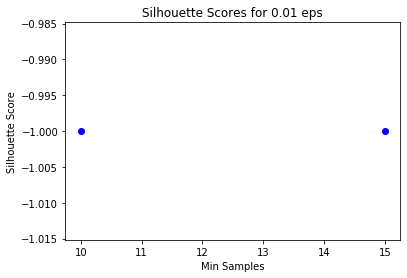

In [42]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

results = [dbscan_find_clusters(eps, min_samples, pca_components) for eps in [0.01, 0.5, 0.7, 1] for min_samples in [2,3,4,5,6,10,15]]

In [187]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

results = [dbscan_find_clusters(eps, min_samples, pca_components) for eps in [0.01, 0.5, 0.7, 1] for min_samples in [2,3,4,5,6,10,15]]

2 min samples and 0.01 eps have -0.0724314842411058 silhouette score.
3 min samples and 0.01 eps have -0.17231332654364356 silhouette score.
4 min samples and 0.01 eps have -0.2202282402578885 silhouette score.
5 min samples and 0.01 eps have -0.2725336870793059 silhouette score.
6 min samples and 0.01 eps have -0.3175719627359371 silhouette score.
10 min samples and 0.01 eps have -0.5206724807075107 silhouette score.
15 min samples and 0.01 eps have -0.6892889450702525 silhouette score.
2 min samples and 0.5 eps have -0.6409176534109918 silhouette score.
3 min samples and 0.5 eps have -0.644597084821491 silhouette score.
4 min samples and 0.5 eps have -0.6514001982144525 silhouette score.
5 min samples and 0.5 eps have -0.6420512587111924 silhouette score.
6 min samples and 0.5 eps have -0.5779892476794523 silhouette score.
10 min samples and 0.5 eps have -0.2593693276921411 silhouette score.
15 min samples and 0.5 eps have 0.1002380385463945 silhouette score.
2 min samples and 0.7 ep

The silhoutte score of the DBSCAN solution: -0.5206724806924923


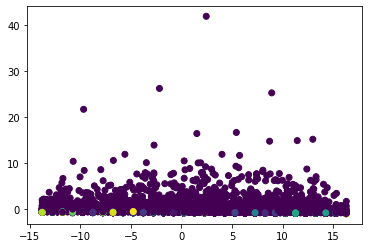

{-1: 4459, 0: 19, 1: 19, 2: 38, 3: 14, 4: 36, 5: 18, 6: 15, 7: 29, 8: 19, 9: 13, 10: 30, 11: 18, 12: 18, 13: 22, 14: 41, 15: 26, 16: 11, 17: 32, 18: 62, 19: 13, 20: 12, 21: 14, 22: 23, 23: 11, 24: 20, 25: 12, 26: 18, 27: 14, 28: 15, 29: 16, 30: 17, 31: 35, 32: 13, 33: 15, 34: 21, 35: 16, 36: 11, 37: 10, 38: 14, 39: 19, 40: 30, 41: 18, 42: 10, 43: 13, 44: 11, 45: 10, 46: 17, 47: 15, 48: 12, 49: 10, 50: 10, 51: 15, 52: 10, 53: 14, 54: 25, 55: 26, 56: 25, 57: 12, 58: 11, 59: 11, 60: 15, 61: 15, 62: 14, 63: 13, 64: 10, 65: 12, 66: 15, 67: 11, 68: 10, 69: 10, 70: 12, 71: 14, 72: 10, 73: 15, 74: 10, 75: 18, 76: 7, 77: 10, 78: 8, 79: 10, 80: 9}
The silhoutte score of the DBSCAN solution: -0.5779892476789071


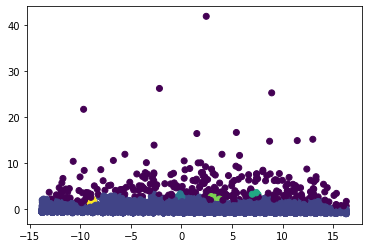

{-1: 279, 0: 5525, 1: 8, 2: 6, 3: 8, 4: 5}


In [184]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
dbscan_cluster = DBSCAN(eps=0.01, min_samples=10)
clusters = dbscan_cluster.fit_predict(pca_components)  
print("The silhoutte score of the DBSCAN solution: {}".format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
plt.show()

unique, counts = np.unique(dbscan_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=6)
clusters = dbscan_cluster.fit_predict(pca_components)  
print("The silhoutte score of the DBSCAN solution: {}".format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
plt.show()

unique, counts = np.unique(dbscan_cluster.labels_, return_counts=True)
print(dict(zip(unique, counts)))

## GMM with PCA Components for All Features

In [34]:
def gmm_find_clusters(n_components, covariance_type, X):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    labels = gmm.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_gmm = {}
    if num_labels == 1 or num_labels == num_samples:
          silhouette = -1
          silhouettes_dbscan[silhouette] = min_samples
          print('{} n components and {} covariance have no clusters.'.format(n_components, covariance_type))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          return {
            'n_components': n_components,
            'covariance_type': covariance_type,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = n_components
    plt.title('Silhouette Scores for {} covariance'.format(covariance_type))
    plt.scatter(list(silhouettes_gmm.values()), list(silhouettes_gmm.keys()), color='blue')
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    # plotting the silhouette scores
# plt.title('Silhouette Scores for Number of Clusters')  
# plt.scatter(list(silhouettes_aggpca_ward.values()), list(silhouettes_aggpca_ward.keys()), color='blue')
# plt.scatter(list(silhouettes_aggpca_complete.values()), list(silhouettes_aggpca_complete.keys()), color='green')
# plt.scatter(list(silhouettes_aggpca_average.values()), list(silhouettes_aggpca_average.keys()), color='red')
# plt.show()


# print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_ward.keys()), silhouettes_aggpca_ward[max(silhouettes_aggpca_ward.keys())]))
# print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_complete.keys()), silhouettes_aggpca_complete[max(silhouettes_aggpca_complete.keys())]))
# print('Best Silhouette score with average linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_average.keys()), silhouettes_aggpca_average[max(silhouettes_aggpca_average.keys())]))
# print('Best Davies Bouldin score: ', min(dbs_aggpca))


In [35]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)

results = [gmm_find_clusters(n_components,covariance_type, pca_components) for n_components in [2,3,4,5,6,10]
           for covariance_type in ['full','tied','diag','spherical']]

In [ ]:
# With PCA components from features with greater than 0.01 correlation

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
silhouettes_gmmumap = []
n_components = [2, 3, 4, 5, 6]
dbs_gmmpca = []



# looping through cluster numbers to find the best cluster
silhouettes_gmmpca_full = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='full')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_full[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_tied = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='tied')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_tied[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_diag = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='diag')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_diag[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_spherical = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='spherical')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_spherical[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)

        
# plotting the silhouette scores
 
fig, ax = plt.subplots()
ax.scatter(list(silhouettes_gmmpca_full.values()), list(silhouettes_gmmpca_full.keys()), color='blue', label='full')
ax.scatter(list(silhouettes_gmmpca_tied.values()), list(silhouettes_gmmpca_tied.keys()), color='green', label='tied')
ax.scatter(list(silhouettes_gmmpca_diag.values()), list(silhouettes_gmmpca_diag.keys()), color='red', label='diag')
ax.scatter(list(silhouettes_gmmpca_spherical.values()), list(silhouettes_gmmpca_spherical.keys()), color='pink', label='spherical')
plt.title('Silhouette Scores for Number of n_components') 
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.75))
plt.show()


print('Best Silhouette score with full covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_full.keys()), silhouettes_gmmpca_full[max(silhouettes_gmmpca_full.keys())]))
print('Best Silhouette score with tied covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_tied.keys()), silhouettes_gmmpca_tied[max(silhouettes_gmmpca_tied.keys())]))
print('Best Silhouette score with diag covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_diag.keys()), silhouettes_gmmpca_diag[max(silhouettes_gmmpca_diag.keys())]))
print('Best Silhouette score with spherical covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_spherical.keys()), silhouettes_gmmpca_spherical[max(silhouettes_gmmpca_spherical.keys())]))

GMM with full covariance type and two components.
The silhoutte score of the GMM solution: 0.5205699675045286
The Davies Boulding Index is:  0.6951858595123831


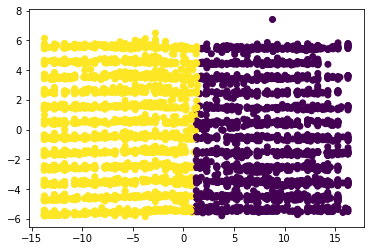



GMM with tied covariance type and two components.
The silhoutte score of the GMM solution: 0.520520813566097
The Davies Boulding Index is:  0.6950587334667994


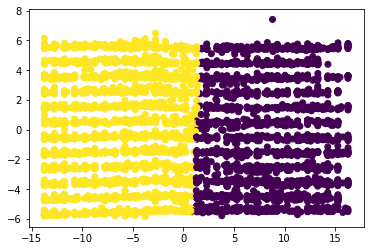



GMM with diag covariance type and two components.
The silhoutte score of the GMM solution: 0.5207073751420738
The Davies Boulding Index is:  0.6956677635472472


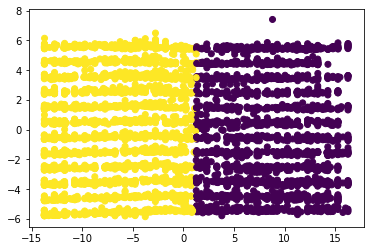



GMM with spherical covariance type and two components.
The silhoutte score of the GMM solution: 0.5208154087730467
The Davies Boulding Index is:  0.6960018525454644


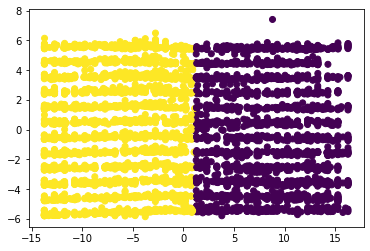

In [26]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for c_type in covariance_types:
        gmm_cluster = GaussianMixture(n_components=2, random_state=123, 
                                     covariance_type=c_type)
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        print('GMM with', c_type, 'covariance type and two components.')
        print("The silhoutte score of the GMM solution: {}".format(metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')))
        print('The Davies Boulding Index is: ', metrics.davies_bouldin_score(pca_components, cluster_labels))
        plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
        plt.show()
        print('\n')

## GMM with PCA Components for Features Highly Coorrelated with humansDeaths

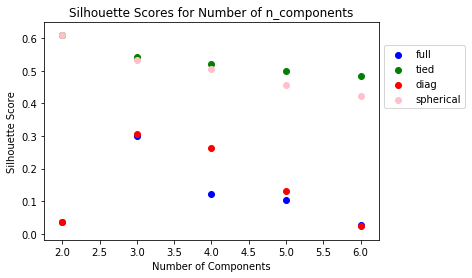

Best Silhouette score with full covariance is 0.3012368825289236 with 3 number of components. 
Best Silhouette score with tied covariance is 0.6086984166373647 with 2 number of components. 
Best Silhouette score with diag covariance is 0.3057620453348315 with 3 number of components. 
Best Silhouette score with spherical covariance is 0.6093899989392665 with 2 number of components. 


In [28]:
# With PCA components from features with greater than 0.01 correlation

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
silhouettes_gmmumap = []
n_components = [2, 3, 4, 5, 6]
dbs_gmmpca = []



# looping through cluster numbers to find the best cluster
silhouettes_gmmpca_full = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='full')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_full[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_tied = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='tied')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_tied[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_diag = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='diag')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_diag[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)
        
silhouettes_gmmpca_spherical = {} # silhoutte scores are keys, n_components are values
for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type='spherical')
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_gmmpca_spherical[silhouette] = n
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_gmmpca.append(db)

        
# plotting the silhouette scores
 
fig, ax = plt.subplots()
ax.scatter(list(silhouettes_gmmpca_full.values()), list(silhouettes_gmmpca_full.keys()), color='blue', label='full')
ax.scatter(list(silhouettes_gmmpca_tied.values()), list(silhouettes_gmmpca_tied.keys()), color='green', label='tied')
ax.scatter(list(silhouettes_gmmpca_diag.values()), list(silhouettes_gmmpca_diag.keys()), color='red', label='diag')
ax.scatter(list(silhouettes_gmmpca_spherical.values()), list(silhouettes_gmmpca_spherical.keys()), color='pink', label='spherical')
plt.title('Silhouette Scores for Number of n_components') 
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.75))
plt.show()


print('Best Silhouette score with full covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_full.keys()), silhouettes_gmmpca_full[max(silhouettes_gmmpca_full.keys())]))
print('Best Silhouette score with tied covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_tied.keys()), silhouettes_gmmpca_tied[max(silhouettes_gmmpca_tied.keys())]))
print('Best Silhouette score with diag covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_diag.keys()), silhouettes_gmmpca_diag[max(silhouettes_gmmpca_diag.keys())]))
print('Best Silhouette score with spherical covariance is {} with {} number of components. '.format(max(silhouettes_gmmpca_spherical.keys()), silhouettes_gmmpca_spherical[max(silhouettes_gmmpca_spherical.keys())]))

GMM with tied covariance type and two components.
The silhoutte score of the GMM solution: 0.6086984166371723
The Davies Boulding Index is:  0.5287730758949677


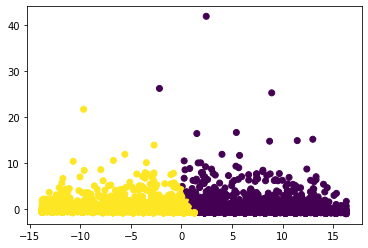





GMM with spherical covariance type and two components.
The silhoutte score of the GMM solution: 0.6093899989390545
The Davies Boulding Index is:  0.5310207708323184


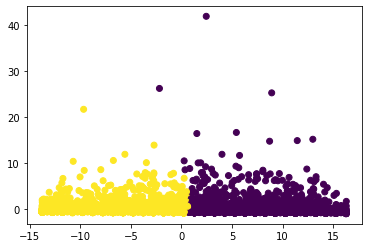

In [30]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)
covariance_types = ['tied', 'spherical']

for c_type in covariance_types:
        gmm_cluster = GaussianMixture(n_components=2, random_state=123, 
                                     covariance_type=c_type)
        cluster_labels = gmm_cluster.fit_predict(pca_components)
        print('GMM with', c_type, 'covariance type and two components.')
        print("The silhoutte score of the GMM solution: {}".format(metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')))
        print('The Davies Boulding Index is: ', metrics.davies_bouldin_score(pca_components, cluster_labels))
        plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
        plt.show()
        print('\n\n\n')

In [33]:
# K-means with all variables

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

labels = gmm_cluster = GaussianMixture(n_components=2, random_state=123, 
                                     covariance_type='spherical').fit_predict(pca_components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_pca_gmm_clusters'] = labels
group_0 = X[X['X_hd_pca_gmm_clusters'] == 0]
group_1 = X[X['X_hd_pca_gmm_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(5831, 282)
5831
{0: 2631, 1: 3200}
sumAtRisk : [3.49516092] [0.0004773]
sumCases : [2.73242153] [0.00630601]
sumDeaths : [2.30654618] [0.02111503]
sumDestroyed : [2.41202615] [0.01589484]
sumSlaughtered : [0.39506835] [0.6928069]
humansAffected : [4.93686764] [8.1597536e-07]
humansDeaths : [4.91072896] [9.32129442e-07]
humansAge : [-0.06461125] [0.94848574]
differenceInDays : [-7.00524411] [2.74362919e-12]
observationYear : [0.63271437] [0.526945]
observationMonth : [1.24056172] [0.21481763]
observationDay : [131.42849783] [0.]
observationFirstHalfMonth : [-322.70663274] [0.]
observationSecondHalfMonth : [322.70663274] [0.]
EC : [2.33588641] [0.01953089]
FAO ECTAD RAF : [-0.90673172] [0.36458616]
FAO Field Officer : [0.90241887] [0.36687169]
FAO officer : [-1.03951901] [0.29860654]
FAO-Report : [-0.90673172] [0.36458616]
International reference laboratory : [0.11861657] [0.90558322]
Media : [1.10286568] [0.27013103]
National Institute for Communicable Diseases, NICD : [1.85488905] [0.

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


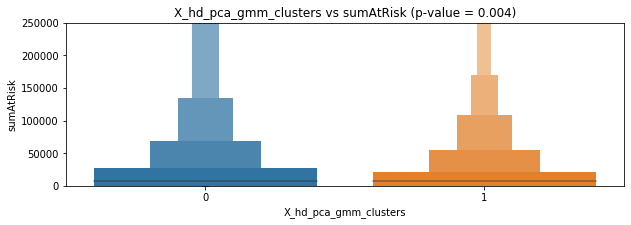

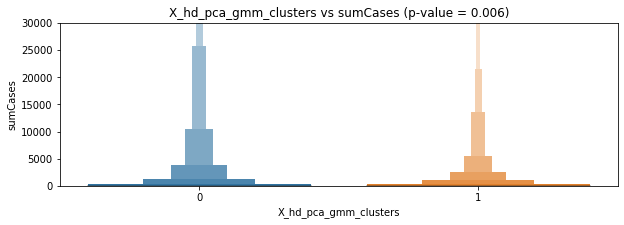

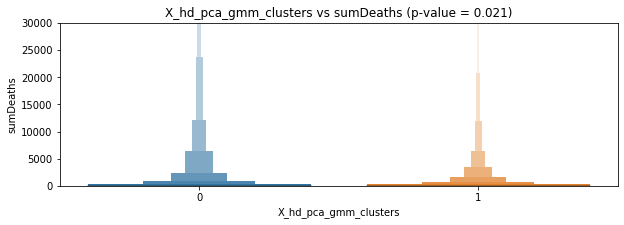

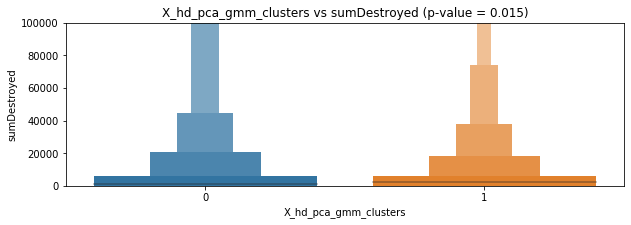

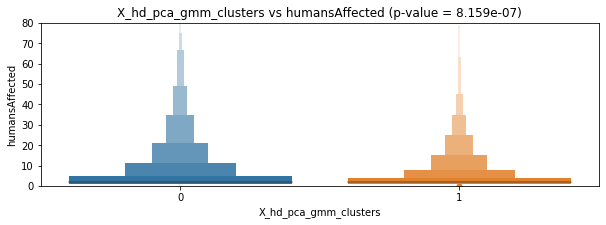

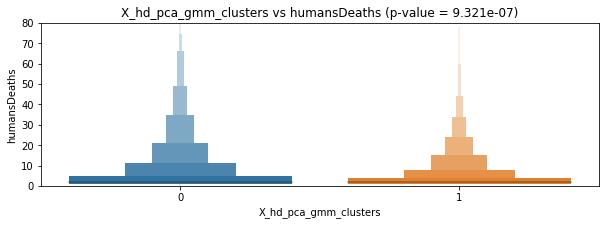

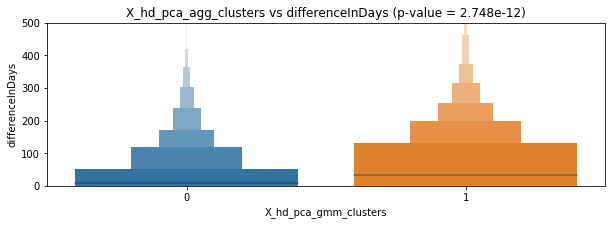

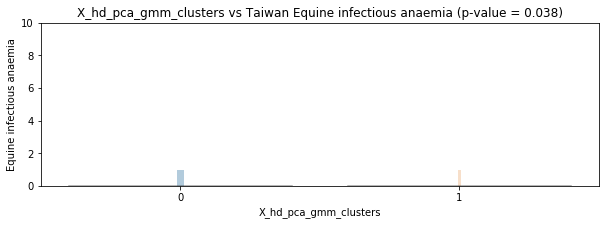

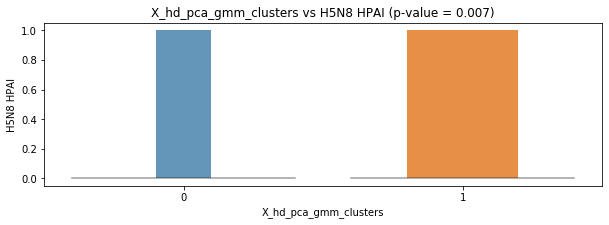

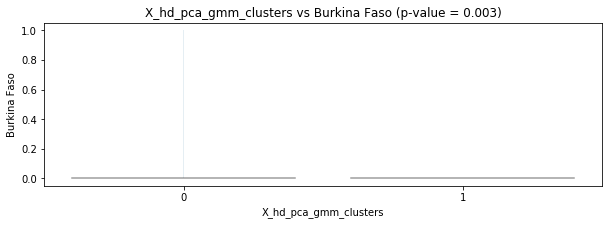

In [39]:
plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['sumAtRisk'])
plt.title('X_hd_pca_gmm_clusters vs sumAtRisk (p-value = 0.004)')
box.set_ylim(0, 250000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['sumCases'])
plt.title('X_hd_pca_gmm_clusters vs sumCases (p-value = 0.006)')
box.set_ylim(0, 30000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['sumDeaths'])
plt.title('X_hd_pca_gmm_clusters vs sumDeaths (p-value = 0.021)')
box.set_ylim(0, 30000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['sumDestroyed'])
plt.title('X_hd_pca_gmm_clusters vs sumDestroyed (p-value = 0.015)')
box.set_ylim(0, 100000)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['humansAffected'])
plt.title('X_hd_pca_gmm_clusters vs humansAffected (p-value = 8.159e-07)')
box.set_ylim(0, 80)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['humansDeaths'])
plt.title('X_hd_pca_gmm_clusters vs humansDeaths (p-value = 9.321e-07)')
box.set_ylim(0, 80)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['differenceInDays'])
plt.title('X_hd_pca_agg_clusters vs differenceInDays (p-value = 2.748e-12)')
box.set_ylim(0, 500)
plt.show()

plt.figure(figsize=(10,3))
box = sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['Equine infectious anaemia'])
plt.title('X_hd_pca_gmm_clusters vs Taiwan Equine infectious anaemia (p-value = 0.038)')
box.set_ylim(0, 10)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['H5N8 HPAI'])
plt.title('X_hd_pca_gmm_clusters vs H5N8 HPAI (p-value = 0.007)')
# scatterplot.set_ylim(0, 600)
plt.show()

plt.figure(figsize=(10,3))
sns.boxenplot(x=X['X_hd_pca_gmm_clusters'], y=X['Burkina Faso'])
plt.title('X_hd_pca_gmm_clusters vs Burkina Faso (p-value = 0.003)')
# scatterplot.set_ylim(0, 600)
plt.show()

The Silhoutte score with ward linkage and 2 clusters: 0.7684065673167959
The Davies Bouldin score with ward linkage and 2 clusters: 0.28679159609737437


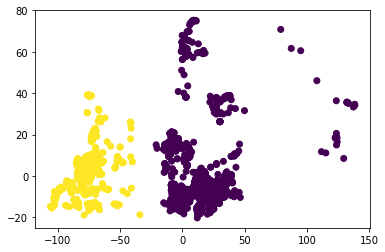



The Silhoutte score with ward linkage and 3 clusters: 0.6492824821336882
The Davies Bouldin score with ward linkage and 3 clusters: 0.5499478384795946


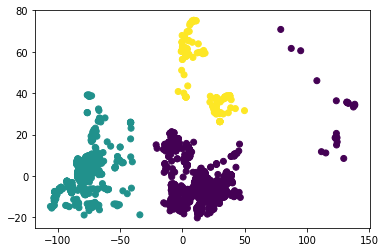



The Silhoutte score with ward linkage and 4 clusters: 0.5189059332243267
The Davies Bouldin score with ward linkage and 4 clusters: 0.6192508920854649


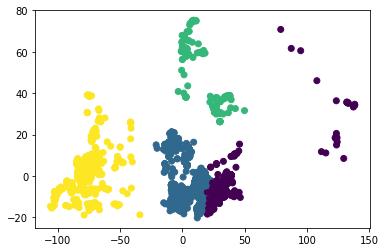



The Silhoutte score with complete linkage and 2 clusters: 0.7684065673167959
The Davies Bouldin score with complete linkage and 2 clusters: 0.28679159609737437


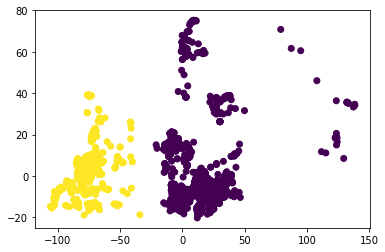



The Silhoutte score with complete linkage and 3 clusters: 0.7652713543160644
The Davies Bouldin score with complete linkage and 3 clusters: 0.3037257202115319


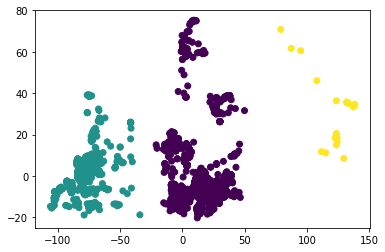



The Silhoutte score with complete linkage and 4 clusters: 0.6649080538428584
The Davies Bouldin score with complete linkage and 4 clusters: 0.4919765284102729


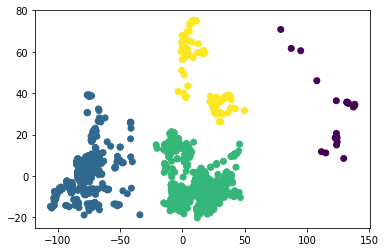



The Silhoutte score with average linkage and 2 clusters: 0.644084372021003
The Davies Bouldin score with average linkage and 2 clusters: 0.4258475534579252


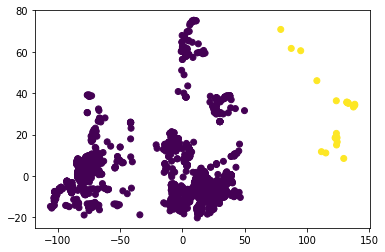



The Silhoutte score with average linkage and 3 clusters: 0.7652713543160644
The Davies Bouldin score with average linkage and 3 clusters: 0.3037257202115318


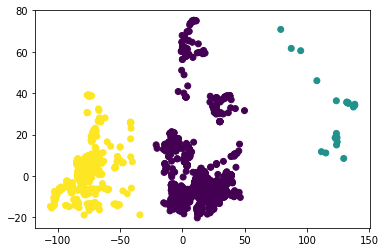



The Silhoutte score with average linkage and 4 clusters: 0.6649080538428584
The Davies Bouldin score with average linkage and 4 clusters: 0.49197652841027284


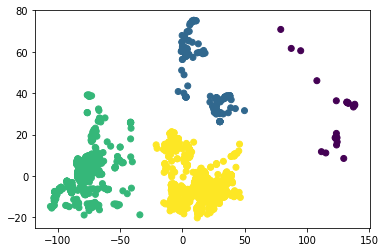



The greatest silhouette score is 0.7684065673167959.


In [59]:
# With PCA components from features with greater than 0.01 correlation
X_01_agg = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'Uknown', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01_agg)
silhouettes_aggpca = []
db_aggpca = []

linkage_types = ['ward', 'complete', 'average']
numbers = [2, 3, 4]
silhouettes = []
for link in linkage_types:
    for cluster in numbers:
        agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        clusters = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
        db = metrics.davies_bouldin_score(pca_components, clusters)
        print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(silhouette))
        print('The Davies Bouldin score with', link,'linkage and', cluster, 'clusters: {}'.format(db))
        plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
        plt.show()
        silhouettes_aggpca.append(metrics.silhouette_score(pca_components, clusters, metric='euclidean'))
        db_aggpca.append(db)
        print('\n')
        
print('The greatest silhouette score is {}.'.format(max(silhouettes_aggpca)))

In [53]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
X_01_agg['2agg_pca_clusters'] = clusters

print('norm_sumSlaughtered: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumCases'].mean())
print('norm_sumDeaths: ', X_01_agg.groupby('2agg_pca_clusters')['norm_sumDeaths'].mean())
print('norm_humansAffected: ', X_01_agg.groupby('2agg_pca_clusters')['norm_humansAffected'].mean())

X_01_agg.head(20)

{0: 3237, 1: 763}
norm_sumSlaughtered:  2agg_pca_clusters
0    0.003461
1    0.010107
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  2agg_pca_clusters
0    0.003938
1    0.013061
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  2agg_pca_clusters
0    0.943466
1    0.927916
Name: norm_sumCases, dtype: float64
norm_sumDeaths:  2agg_pca_clusters
0    0.492431
1    0.858453
Name: norm_sumDeaths, dtype: float64
norm_humansAffected:  2agg_pca_clusters
0    0.008864
1    0.008876
Name: norm_humansAffected, dtype: float64


,Saudi Arabia,H5N8 HPAI,H5N2 HPAI,Portugal,WHO,Centroid Admin1,Asia,OIE,Other,National authorities,Europe,Jordan,latitude,Exact,Centroid Locality,observationYear,Uknown,longitude,mammals,Bluetongue,birds,H7N9 LPAI,African swine fever,France,China,H5N8 HPAI,wild,8,observationMonth,Lumpy skin disease,Taiwan (Province of China),Malaysia,Rabies,Africa,unspecified,4,FAO Field Officer,H5N1 HPAI,Albania,Latvia,Serbia,Estonia,Russian Federation,Republic of Korea,norm_sumAtRisk,norm_sumCases,norm_sumDeaths,norm_sumDestroyed,norm_sumSlaughtered,norm_humansAge,norm_humansAffected,norm_differenceInDays,2agg_pca_clusters
7756,0,0,0,0,0,0,0,1,0,0,1,0,43.688870,1,0,2016,0,19.885310,1,1,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.012938,0
16209,0,0,0,0,0,0,0,1,0,0,1,0,56.828600,1,0,2015,1,25.980000,1,0,0,0,1,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,0.0,0.000000,0.002556,0.008884,0.008864,0.003753,0
543,0,0,0,0,0,1,0,0,0,1,1,0,40.355140,0,0,2017,1,19.626310,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.014562,0.017024,0.008884,0.008864,0.001616,0
7864,0,0,0,0,0,0,0,1,0,0,1,0,46.894474,1,0,2016,0,5.093447,0,1,0,0,0,1,0,0,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.011220,0
9898,0,0,0,0,0,0,0,1,0,0,1,0,45.612420,1,0,2016,0,3.682880,0,1,0,0,0,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005980,0
525,0,0,0,0,0,0,1,0,0,1,0,0,23.982560,0,0,2017,0,106.707275,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.014562,0.017024,0.015661,0.008864,0.008152,1
14178,0,0,0,0,0,0,0,1,0,0,0,0,11.891864,1,0,2016,0,8.141939,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1.0,1.0,1.0,0.012000,0.000000,0.008884,0.008864,0.009546,0
16480,0,0,0,0,0,0,0,1,0,0,0,0,-19.762350,1,0,2015,0,29.657160,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.010851,0
2741,0,1,0,0,0,0,0,1,0,0,1,0,43.672779,1,0,2017,0,-0.989154,0,0,1,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005591,0
16485,0,0,0,0,0,0,0,1,0,0,1,0,56.953300,1,0,2015,1,25.981900,1,0,0,0,1,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,1.0,0.000000,0.000000,0.008884,0.008864,0.012511,0


The Silhoutte score with average linkage and 4 clusters: 0.6322573657405146


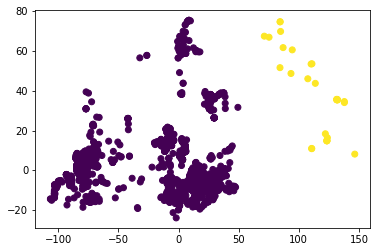



{0: 3969, 1: 31}
norm_sumSlaughtered:  agg_pca_complete_clusters
0    0.004740
1    0.003295
Name: norm_sumSlaughtered, dtype: float64
norm_sumDestroyed:  agg_pca_complete_clusters
0    0.005672
1    0.006450
Name: norm_sumDestroyed, dtype: float64
norm_sumCases:  agg_pca_complete_clusters
0    0.941547
1    0.806452
Name: norm_sumCases, dtype: float64
norm_sumDeaths:  agg_pca_complete_clusters
0    0.562862
1    0.483871
Name: norm_sumDeaths, dtype: float64
norm_humansAffected:  agg_pca_complete_clusters
0    0.008866
1    0.008864
Name: norm_humansAffected, dtype: float64


,Saudi Arabia,H5N8 HPAI,H5N2 HPAI,Portugal,WHO,Centroid Admin1,Asia,OIE,Other,National authorities,Europe,Jordan,latitude,Exact,Centroid Locality,observationYear,Uknown,longitude,mammals,Bluetongue,birds,H7N9 LPAI,African swine fever,France,China,H5N8 HPAI,wild,8,observationMonth,Lumpy skin disease,Taiwan (Province of China),Malaysia,Rabies,Africa,unspecified,4,FAO Field Officer,H5N1 HPAI,Albania,Latvia,Serbia,Estonia,Russian Federation,Republic of Korea,norm_sumAtRisk,norm_sumCases,norm_sumDeaths,norm_sumDestroyed,norm_sumSlaughtered,norm_humansAge,norm_humansAffected,norm_differenceInDays,2agg_pca_clusters,agg_pca_complete_clusters
7756,0,0,0,0,0,0,0,1,0,0,1,0,43.688870,1,0,2016,0,19.885310,1,1,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.012938,0,0
16209,0,0,0,0,0,0,0,1,0,0,1,0,56.828600,1,0,2015,1,25.980000,1,0,0,0,1,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,0.0,0.000000,0.002556,0.008884,0.008864,0.003753,0,0
543,0,0,0,0,0,1,0,0,0,1,1,0,40.355140,0,0,2017,1,19.626310,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.014562,0.017024,0.008884,0.008864,0.001616,0,0
7864,0,0,0,0,0,0,0,1,0,0,1,0,46.894474,1,0,2016,0,5.093447,0,1,0,0,0,1,0,0,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.011220,0,0
9898,0,0,0,0,0,0,0,1,0,0,1,0,45.612420,1,0,2016,0,3.682880,0,1,0,0,0,1,0,0,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005980,0,0
525,0,0,0,0,0,0,1,0,0,1,0,0,23.982560,0,0,2017,0,106.707275,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.014562,0.017024,0.015661,0.008864,0.008152,1,0
14178,0,0,0,0,0,0,0,1,0,0,0,0,11.891864,1,0,2016,0,8.141939,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1.0,1.0,1.0,0.012000,0.000000,0.008884,0.008864,0.009546,0,0
16480,0,0,0,0,0,0,0,1,0,0,0,0,-19.762350,1,0,2015,0,29.657160,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.000000,0.000000,0.008884,0.008864,0.010851,0,0
2741,0,1,0,0,0,0,0,1,0,0,1,0,43.672779,1,0,2017,0,-0.989154,0,0,1,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.008884,0.008864,0.005591,0,0
16485,0,0,0,0,0,0,0,1,0,0,1,0,56.953300,1,0,2015,1,25.981900,1,0,0,0,1,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0,1.0,0.000000,0.000000,0.008884,0.008864,0.012511,0,0


In [54]:
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
print('The Silhoutte score with', link,'linkage and', cluster, 'clusters: {}'.format(silhouette))
plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
plt.show()
print('\n')

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
X_01_agg['agg_pca_complete_clusters'] = clusters

print('norm_sumSlaughtered: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumSlaughtered'].mean())
print('norm_sumDestroyed: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumDestroyed'].mean())
print('norm_sumCases: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumCases'].mean())
print('norm_sumDeaths: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_sumDeaths'].mean())
print('norm_humansAffected: ', X_01_agg.groupby('agg_pca_complete_clusters')['norm_humansAffected'].mean())

X_01_agg.head(20)

In [34]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01)

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
clusters = agg_cluster.fit_predict(pca_components)

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))
outbreaks['agg_01_pca'] = clusters
outbreaks.head()

# Visualizations
# plt.figure(figsize=(10,3))
# box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumCases'])
# plt.title('differenceInDays vs sumCases')
# box.set_ylim(0, 15000)
# plt.show()

# plt.figure(figsize=(10,3))
# box = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumAtRisk'])
# plt.title('differenceInDays vs sumAtRisk')
# box.set_ylim(0, 60000)
# plt.show()

# plt.figure(figsize=(10,3))
# bpx = sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['sumDeaths'])
# plt.title('differenceInDays vs sumDeaths')
# box.set_ylim(0, 10000)
# plt.show()

# plt.figure(figsize=(10,3))
# sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansAffected'])
# plt.title('differenceInDays vs humansAffected')
# # scatterplot.set_xlim(0, 600)
# plt.show()

# plt.figure(figsize=(10,3))
# sns.boxenplot(x=outbreaks['k_means_clusters'], y=outbreaks['humansDeaths'])
# plt.title('differenceInDays vs humansAffected')
# # scatterplot.set_xlim(0, 600)
# plt.show()

MemoryError: unable to allocate array data.

0.1 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


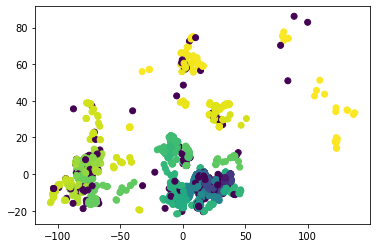



0.1 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


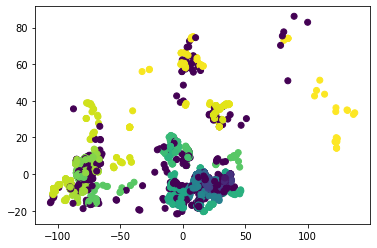



0.1 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


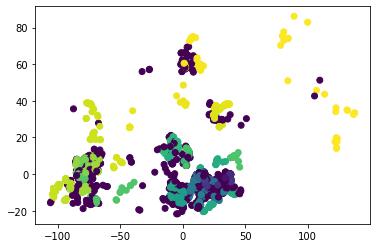



0.5 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


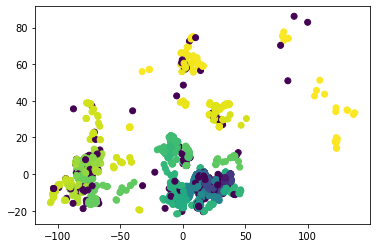



0.5 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


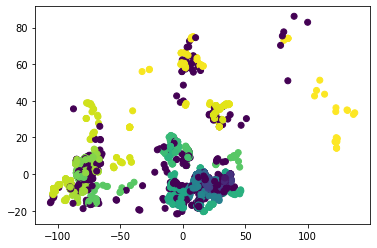



0.5 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


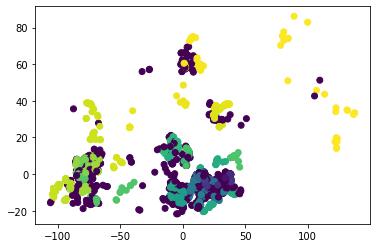



1 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


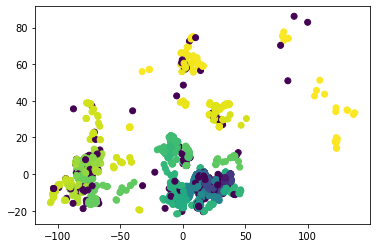



1 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


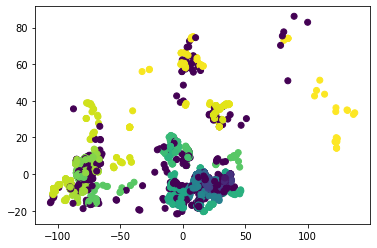



1 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


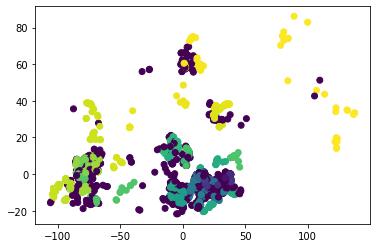



2 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


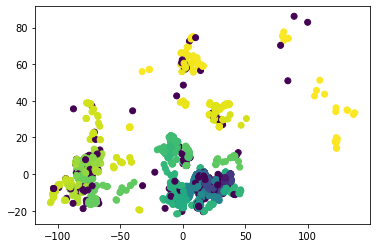



2 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


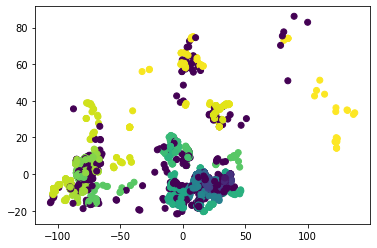



2 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


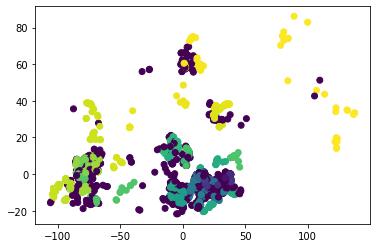



5 eps and 2 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.33412076484528563
The Davies Bouldin score of the OPTICS solution:  1.538990881709987


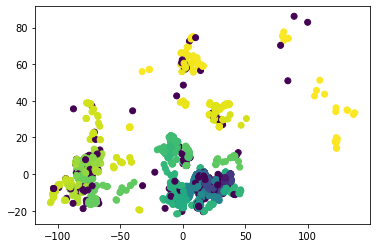



5 eps and 3 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.17414240355410895
The Davies Bouldin score of the OPTICS solution:  1.5787476994929923


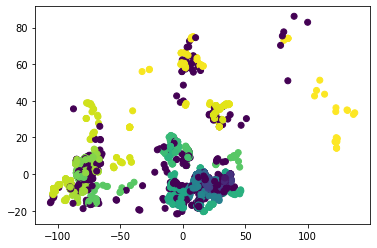



5 eps and 5 min samples.


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


The silhoutte score of the OPTICS solution:  0.028454312857107575
The Davies Bouldin score of the OPTICS solution:  1.6615225935013298


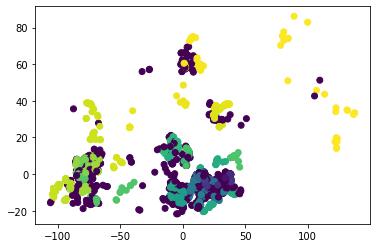



Best Silhouette score:  0.33412076484528563
Best Davis Bouldin score:  1.538990881709987


In [28]:
# With PCA components from features with greater than 0.01 correlation
X_01_optics = outbreaks[['Saudi Arabia', 'H5N8 HPAI', 'H5N2 HPAI', 'Portugal',
                      'WHO', 'Centroid Admin1', 'Asia',  'OIE', 'Other', 'National authorities',
                      'Europe', 'Jordan', 'latitude', 'Exact', 'Centroid Locality', 
                      'observationYear', 'Uknown', 'longitude', 'mammals', 'Bluetongue', 'birds', 'H7N9 LPAI',
                      'African swine fever', 'France', 'China', 'H5N8 HPAI', 'wild', '8',  
                      'observationMonth', 'Lumpy skin disease', 'Taiwan (Province of China)', 'Malaysia', 'Rabies',
                      'Africa', 'unspecified', '4', 'FAO Field Officer', 'H5N1 HPAI', 'Albania',
                      'Latvia', 'Serbia', 'Estonia', 'Russian Federation', 'Republic of Korea', 'norm_sumAtRisk', 
                      'norm_sumCases', 'norm_sumDeaths', 'norm_sumDestroyed','norm_sumSlaughtered', 
                      'norm_humansAge','norm_humansAffected', 'norm_differenceInDays']].sample(n=4000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_01_optics)

silhouettes_optics = []
eps = [0.1, 0.5, 1, 2, 5]
min_samples = [2, 3, 5]
dbs = []

for ep in eps:
    for min_sample in min_samples:
        print(ep, 'eps and', min_sample, 'min samples.')
        optics_cluster = OPTICS(eps=ep, min_samples=min_sample)
        clusters = optics_cluster.fit_predict(pca_components) 
        try: 
            silhouette = metrics.silhouette_score(pca_components, clusters, metric='euclidean')
            print('The silhoutte score of the OPTICS solution: ', silhouette)
            silhouettes_optics.append(silhouette)
            db = metrics.davies_bouldin_score(pca_components, clusters)
            print('The Davies Bouldin score of the OPTICS solution: ', db)
            dbs.append(db)
            plt.scatter(pca_components[:,0], pca_components[:,1], c=clusters)
            plt.show()
            print('\n')
        except ValueError:
            print('\n')
            print('---------------------------------------------------')
            print('DBSCAN with', ep, 'eps and', min_sample, 'min samples was unable to find any clusters.')
            print('---------------------------------------------------')
            print('\n')
            
            
print('Best Silhouette score: ', max(silhouettes_optics))
print('Best Davis Bouldin score: ', min(dbs))

In [ ]:
most optimal configurations for agglomerative clsutering

spektral clustring

In [ ]:
## DBSCAN with PCA components from all features

In [ ]:
# With PCA components from all features
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all.sample(3500))
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


silhouettes_aggpca_complete = {} # silhoutte scores are keys, clusters are values
silhouettes_aggpca_average = {} # silhoutte scores are keys, clusters are values
dbs_aggpca = []
linkage_types = ['ward', 'complete', 'average']


# looping through cluster numbers to find the best cluster
silhouettes_aggpca_ward = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_ward[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_complete = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_complete[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)
        
silhouettes_aggpca_average = {} # silhoutte scores are keys, clusters are values
for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
        cluster_labels = agg_cluster.fit_predict(pca_components)
        silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
        silhouettes_aggpca_average[silhouette] = cluster
        db = metrics.davies_bouldin_score(pca_components, cluster_labels)
        dbs_aggpca.append(db)

# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Clusters')  
plt.scatter(list(silhouettes_aggpca_ward.values()), list(silhouettes_aggpca_ward.keys()), color='blue')
plt.scatter(list(silhouettes_aggpca_complete.values()), list(silhouettes_aggpca_complete.keys()), color='green')
plt.scatter(list(silhouettes_aggpca_average.values()), list(silhouettes_aggpca_average.keys()), color='red')
plt.show()


print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_ward.keys()), silhouettes_aggpca_ward[max(silhouettes_aggpca_ward.keys())]))
print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_complete.keys()), silhouettes_aggpca_complete[max(silhouettes_aggpca_complete.keys())]))
print('Best Silhouette score with average linkage is {} with {} clusters. '.format(max(silhouettes_aggpca_average.keys()), silhouettes_aggpca_average[max(silhouettes_aggpca_average.keys())]))
print('Best Davies Bouldin score: ', min(dbs_aggpca))

In [31]:
import hdbscan
from sklearn.datasets import make_blobs
data, _ = make_blobs(1000)
clusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=7)
cluster_labels = clusterer.fit_predict(data)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.100, 5)
hierarchy.plot()
plt.show()

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
!conda install -c conda-forge hdbscan -y

In [35]:
# With PCA components from all features
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_all.sample(3500))

components = [50, 100, 250]
dbs_rbmpca = []
silhouettes_rbmpca = {}

for component in components:
    rbm_cluster = BernoulliRBM(n_components=256, learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=None)
    cluster_labels = rbm_cluster.fit(pca_components)
    silhouette = metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean')
    silhouettes_rbmpca[silhouette] = component
    db = metrics.davies_bouldin_score(pca_components, cluster_labels)
    dbs_rbmpca.append(db)
    
# plotting the silhouette scores
plt.title('Silhouette Scores for Number of Components')  
plt.scatter(list(silhouettes_rbmpca.values()), list(silhouettes_rbmpca.keys()), color='blue')
plt.show()
    
print('Best Silhouette is {} with {} components'.format(max(silhouettes_rbmpca_dict.keys()), silhouettes_rbmpca_dict[max(silhouettes_rbmpca_dict.keys())]))

ValueError: bad input shape ()